# **Tcs-ion-Rio-125--Forecasting-Retail-Demand**

## Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import time
import warnings
warnings.filterwarnings('ignore')



The chain has ten stores and 50 assortment brands.  The task of this paper is to accurately predict the sales data of 2018 based on the previous data. The characteristic of this case is that different products are distributed in different stores, and at the same time, the sales data has obvious seasonality. The data has significant discrete features. It is difficult to predict it accurately if only numerical prediction is used. Therefore, it is necessary to refer to the programming idea of ​​One-Hot-Encoding, and the discretization of attributes is judged by the binary activation state.

In [2]:
df = pd.read_csv("forecast train.csv")
df.head()

date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10

In [3]:
df.tail()

date  store  item  sales
912995  2017-12-27     10    50     63
912996  2017-12-28     10    50     59
912997  2017-12-29     10    50     74
912998  2017-12-30     10    50     62
912999  2017-12-31     10    50     82

# Understanding Dataset

The time span of the data is from 2013 to 2017.

In [4]:
df.shape

(913000, 4)

In [5]:
df.columns

Index(['date', 'store', 'item', 'sales'], dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [7]:
df.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

Hence no null values in train data.

In [8]:
df['date'].min() ,df['date'].max()

('2013-01-01', '2017-12-31')

In [9]:
df.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T

0.00  0.05  0.50   0.95   0.99   1.00
store   1.0   1.0   5.5   10.0   10.0   10.0
item    1.0   3.0  25.5   48.0   50.0   50.0
sales   0.0  16.0  47.0  107.0  135.0  231.0

In [10]:
df['date'] = pd.to_datetime(df['date'])
import datetime
def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day'] = df.date.dt.day
    df['year'] = df.date.dt.year
    return df

create_date_features(df).head()

date  store  item  sales  month  day  year
0 2013-01-01      1     1     13      1    1  2013
1 2013-01-02      1     1     11      1    2  2013
2 2013-01-03      1     1     14      1    3  2013
3 2013-01-04      1     1     13      1    4  2013
4 2013-01-05      1     1     10      1    5  2013

## Descriptive Statistics

In [11]:
df["sales"].describe([0.10, 0.30, 0.50, 0.70, 0.80, 0.90, 0.95, 0.99])

count    913000.000000
mean         52.250287
std          28.801144
min           0.000000
10%          20.000000
30%          33.000000
50%          47.000000
70%          64.000000
80%          76.000000
90%          93.000000
95%         107.000000
99%         135.000000
max         231.000000
Name: sales, dtype: float64

In [12]:
df[["store"]].nunique()

store    10
dtype: int64

In [13]:
df[["item"]].nunique()

item    50
dtype: int64

In [14]:
df.groupby(["store"])["item"].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [15]:
#details of sales of each stores
store_wise_sale=df.groupby(["store"]).agg({"sales": ["count","sum", "mean", "median", "std", "min", "max"]})
store_wise_sale

sales                                               
       count      sum       mean median        std min  max
store                                                      
1      91300  4315603  47.268379   44.0  24.006252   1  155
2      91300  6120128  67.033165   62.0  33.595810   3  231
3      91300  5435144  59.530602   55.0  29.974102   3  196
4      91300  5012639  54.902946   51.0  27.733097   4  186
5      91300  3631016  39.770164   37.0  20.365757   2  130
6      91300  3627670  39.733516   37.0  20.310451   0  134
7      91300  3320009  36.363735   34.0  18.684825   1  122
8      91300  5856169  64.142048   60.0  32.231751   4  204
9      91300  5025976  55.049025   51.0  27.832186   4  195
10     91300  5360158  58.709288   54.0  29.554994   3  187

In [16]:
#details of sales of each years
year_wise_sale=df.groupby(["year"]).agg({"sales": ["count","sum", "mean", "median", "std", "min", "max"]})
year_wise_sale

sales                                                
       count       sum       mean median        std min  max
year                                                        
2013  182500   7941243  43.513660   39.0  23.625533   1  169
2014  182500   9135482  50.057436   45.0  27.042215   0  189
2015  182500   9536887  52.256915   47.0  28.158359   1  196
2016  183000  10357160  56.596503   51.0  30.433444   2  214
2017  182500  10733740  58.815014   53.0  31.552697   2  231

In [17]:
#details of sales of each month
month_wise_sale=df.groupby(["month"]).agg({"sales": ["count","sum", "mean", "median", "std", "min", "max"]})
month_wise_sale

sales                                               
       count      sum       mean median        std min  max
month                                                      
1      77500  2753149  35.524503   33.0  18.508468   0  120
2      70500  2776177  39.378397   36.0  20.444393   2  136
3      77500  3666182  47.305574   44.0  24.269264   3  161
4      75000  4136467  55.152893   51.0  28.297197   3  182
5      77500  4582437  59.128219   55.0  30.102166   3  195
6      75000  4726911  63.025480   58.0  32.025829   5  198
7      77500  5192393  66.998619   62.0  34.133458   5  231
8      77500  4580655  59.105226   55.0  30.084162   3  201
9      75000  4130457  55.072760   51.0  28.168197   4  183
10     77500  3967520  51.193806   47.0  26.316421   2  168
11     75000  4141356  55.218080   51.0  28.154336   3  187
12     77500  3050808  39.365265   36.0  20.458646   1  135

In [18]:
#details of sales of each items
item_wise_sale=df.groupby(["item"]).agg({"sales": ["count","sum", "mean", "median", "std", "min", "max"]})
item_wise_sale

sales                                               
      count      sum       mean median        std min  max
item                                                      
1     18260   401384  21.981599   21.0   8.468922   1   59
2     18260  1069564  58.574151   56.0  20.093015   9  150
3     18260   669087  36.642223   35.0  13.179441   7  104
4     18260   401907  22.010241   21.0   8.403898   0   66
5     18260   335230  18.358708   18.0   7.265167   1   50
6     18260  1068281  58.503888   56.0  20.174898  11  148
7     18260  1068777  58.531051   56.0  20.146002  11  141
8     18260  1405108  76.950055   74.0  26.130697  15  181
9     18260   938379  51.389869   49.5  17.790158   6  134
10    18260  1337133  73.227437   70.0  24.823725  14  175
11    18260  1271925  69.656353   67.0  23.744732  11  170
12    18260  1271534  69.634940   67.0  23.738663  12  170
13    18260  1539621  84.316594   81.0  28.311031  20  210
14    18260  1071531  58.681873   56.0  20.079860  12  152
15    18260  1607442  88.030778   85.0  29.522852  17  231
16    18260   468480  25.656079   25.0   9.603270   2   70
17    18260   602486  32.994852   32.0  11.967610   4   83
18    18260  1538876  84.275794   81.0  28.430621  18  208
19    18260   736892  40.355531   39.0  14.332645   5   99
20    18260   867641  47.515936   46.0  16.490487   9  127
21    18260   736190  40.317087   39.0  14.338006   7  109
22    18260  1469971  80.502245   78.0  27.118163  14  214
23    18260   534979  29.297864   28.0  10.819549   3   81
24    18260  1205975  66.044633   64.0  22.531555  14  156
25    18260  1473334  80.686418   78.0  27.238817  18  193
26    18260   869981  47.644085   46.0  16.723912   8  119
27    18260   402628  22.049726   21.0   8.461641   1   59
28    18260  1604713  87.881325   85.0  29.501781  16  206
29    18260  1271240  69.618839   67.0  23.635631  15  173
30    18260   736554  40.337021   39.0  14.363331   5  115
31    18260  1070845  58.644304   57.0  20.104705  10  159
32    18260   803107  43.981763   42.0  15.574556   5  119
33    18260  1270183  69.560953   67.0  23.718343  15  169
34    18260   469935  25.735761   25.0   9.617910   2   79
35    18260  1201541  65.801807   63.0  22.461990  12  168
36    18260  1406548  77.028916   74.0  26.067440  16  188
37    18260   534258  29.258379   28.0  10.771547   3   74
38    18260  1470330  80.521906   77.0  27.141799  15  188
39    18260   801311  43.883406   42.0  15.511550   7  112
40    18260   534094  29.249398   28.0  10.822959   3   74
41    18260   401759  22.002136   21.0   8.402470   2   60
42    18260   669925  36.688116   35.0  13.215112   5   96
43    18260   936635  51.294359   49.0  17.801008   9  126
44    18260   536811  29.398193   28.0  10.797738   3   78
45    18260  1471467  80.584173   78.0  27.318402  18  205
46    18260  1070764  58.639869   56.0  20.220879  11  150
47    18260   401781  22.003341   21.0   8.420102   2   61
48    18260   937703  51.352848   49.0  17.881917   8  130
49    18260   535663  29.335323   28.0  10.874788   3   77
50    18260  1203009  65.882202   63.0  22.416031  12  164

In [19]:
#details of sales of each stores and items
store_item_wise_sale=df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})
store_item_wise_sale

sales                             
               sum       mean median        std
store item                                     
1     1      36468  19.971522   19.0   6.741022
      2      97050  53.148959   52.0  15.005779
      3      60638  33.208105   33.0  10.072529
      4      36440  19.956188   20.0   6.640618
      5      30335  16.612815   16.0   5.672102
...            ...        ...    ...        ...
10    46    120601  66.046550   65.0  18.114991
      47     45204  24.755750   24.0   7.924820
      48    105570  57.814896   57.0  15.898538
      49     60317  33.032311   32.0  10.091610
      50    135192  74.037240   73.0  19.937566

[500 rows x 4 columns]

In [20]:
#details of sales of each stores and years
store_year_wise_sale=df.groupby(["store", "year"]).agg({"sales": ["sum", "mean", "median", "std"]})
store_year_wise_sale

sales                             
                sum       mean median        std
store year                                      
1     2013   717840  39.333699   37.0  19.676545
      2014   826786  45.303342   42.0  22.498525
      2015   861710  47.216986   44.0  23.360461
      2016   937493  51.229126   48.0  25.249487
      2017   971774  53.247890   50.0  26.202036
2     2013  1020238  55.903452   52.0  27.526278
      2014  1171797  64.208055   60.0  31.384987
      2015  1222184  66.968986   63.0  32.694459
      2016  1329523  72.651530   68.0  35.382065
      2017  1376386  75.418411   71.0  36.687015
3     2013   903936  49.530740   46.0  24.461761
      2014  1040520  57.014795   53.0  28.077968
      2015  1086103  59.512493   56.0  29.206245
      2016  1180619  64.514699   61.0  31.607241
      2017  1223966  67.066630   63.0  32.639617
4     2013   835059  45.756658   43.0  22.739009
      2014   959205  52.559178   49.0  25.890286
      2015  1002730  54.944110   51.5  27.030908
      2016  1088195  59.464208   56.0  29.231686
      2017  1127450  61.778082   58.0  30.261185
5     2013   603783  33.084000   31.0  16.714114
      2014   695599  38.115014   36.0  19.149283
      2015   725342  39.744767   37.0  19.848394
      2016   789271  43.129563   40.0  21.361825
      2017   817021  44.768274   42.0  22.219523
6     2013   604373  33.116329   31.0  16.652904
      2014   695214  38.093918   36.0  18.996343
      2015   725917  39.776274   37.0  19.821840
      2016   786299  42.967158   40.0  21.345883
      2017   815867  44.705041   42.0  22.229014
7     2013   552223  30.258795   28.0  15.365770
      2014   635978  34.848110   33.0  17.487659
      2015   664267  36.398192   34.0  18.182370
      2016   720382  39.365137   37.0  19.697827
      2017   747159  40.940219   38.0  20.383957
8     2013   974655  53.405753   50.0  26.286126
      2014  1121897  61.473808   58.0  30.154475
      2015  1171046  64.166904   60.0  31.551877
      2016  1270695  69.436885   65.0  33.834117
      2017  1317876  72.212384   68.0  35.188111
9     2013   835788  45.796603   43.0  22.682190
      2014   961779  52.700219   49.0  26.104694
      2015  1006021  55.124438   52.0  27.030638
      2016  1090831  59.608251   56.0  29.374348
      2017  1131557  62.003123   58.0  30.385766
10    2013   893348  48.950575   46.0  24.206325
      2014  1026707  56.257918   53.0  27.726879
      2015  1071567  58.716000   55.0  28.809585
      2016  1163852  63.598470   60.0  31.101648
      2017  1204684  66.010082   62.0  32.200457

In [21]:
#details of sales of each stores and years
store_year_wise_sale=df.groupby(["year", "store" ]).agg({"sales": ["sum", "mean", "median", "std"]})
store_year_wise_sale

sales                             
                sum       mean median        std
year store                                      
2013 1       717840  39.333699   37.0  19.676545
     2      1020238  55.903452   52.0  27.526278
     3       903936  49.530740   46.0  24.461761
     4       835059  45.756658   43.0  22.739009
     5       603783  33.084000   31.0  16.714114
     6       604373  33.116329   31.0  16.652904
     7       552223  30.258795   28.0  15.365770
     8       974655  53.405753   50.0  26.286126
     9       835788  45.796603   43.0  22.682190
     10      893348  48.950575   46.0  24.206325
2014 1       826786  45.303342   42.0  22.498525
     2      1171797  64.208055   60.0  31.384987
     3      1040520  57.014795   53.0  28.077968
     4       959205  52.559178   49.0  25.890286
     5       695599  38.115014   36.0  19.149283
     6       695214  38.093918   36.0  18.996343
     7       635978  34.848110   33.0  17.487659
     8      1121897  61.473808   58.0  30.154475
     9       961779  52.700219   49.0  26.104694
     10     1026707  56.257918   53.0  27.726879
2015 1       861710  47.216986   44.0  23.360461
     2      1222184  66.968986   63.0  32.694459
     3      1086103  59.512493   56.0  29.206245
     4      1002730  54.944110   51.5  27.030908
     5       725342  39.744767   37.0  19.848394
     6       725917  39.776274   37.0  19.821840
     7       664267  36.398192   34.0  18.182370
     8      1171046  64.166904   60.0  31.551877
     9      1006021  55.124438   52.0  27.030638
     10     1071567  58.716000   55.0  28.809585
2016 1       937493  51.229126   48.0  25.249487
     2      1329523  72.651530   68.0  35.382065
     3      1180619  64.514699   61.0  31.607241
     4      1088195  59.464208   56.0  29.231686
     5       789271  43.129563   40.0  21.361825
     6       786299  42.967158   40.0  21.345883
     7       720382  39.365137   37.0  19.697827
     8      1270695  69.436885   65.0  33.834117
     9      1090831  59.608251   56.0  29.374348
     10     1163852  63.598470   60.0  31.101648
2017 1       971774  53.247890   50.0  26.202036
     2      1376386  75.418411   71.0  36.687015
     3      1223966  67.066630   63.0  32.639617
     4      1127450  61.778082   58.0  30.261185
     5       817021  44.768274   42.0  22.219523
     6       815867  44.705041   42.0  22.229014
     7       747159  40.940219   38.0  20.383957
     8      1317876  72.212384   68.0  35.188111
     9      1131557  62.003123   58.0  30.385766
     10     1204684  66.010082   62.0  32.200457

In [22]:
#details of sales of each stores and month
store_month_wise_sale=df.groupby(["store", "month"]).agg({"sales": ["sum", "mean", "median", "std"]})
store_month_wise_sale

sales                             
                sum       mean median        std
store month                                     
1     1      249352  32.174452   31.0  15.485652
      2      250494  35.531064   34.0  16.907255
      3      331214  42.737290   41.0  19.917487
      4      374268  49.902400   48.0  23.409806
      5      414653  53.503613   51.0  24.741751
...             ...        ...    ...        ...
10    8      515431  66.507226   64.0  30.618790
      9      463283  61.771067   59.0  28.381843
      10     446433  57.604258   55.0  26.606221
      11     465091  62.012133   60.0  28.494022
      12     342656  44.213677   42.0  20.741314

[120 rows x 4 columns]

In [23]:
#details of sales of each stores,years and items
sale=df.groupby(["store", "item", "year"]).agg({"sales": ["sum", "mean", "median", "std"]})
sale

sales                             
                   sum       mean median        std
store item year                                    
1     1    2013   6025  16.506849   16.0   5.568069
           2014   6889  18.873973   19.0   5.910087
           2015   7507  20.567123   20.0   6.859982
           2016   7950  21.721311   22.0   6.691965
           2017   8097  22.183562   22.0   6.953278
...                ...        ...    ...        ...
10    50   2013  22472  61.567123   60.0  15.815697
           2014  25927  71.032877   70.0  17.430364
           2015  27081  74.194521   74.0  19.141405
           2016  29452  80.469945   82.0  18.974328
           2017  30260  82.904110   81.0  20.644136

[2500 rows x 4 columns]

# EDA

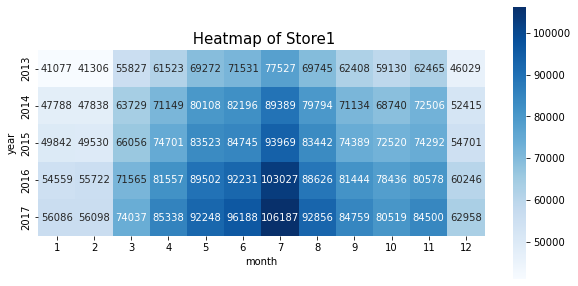

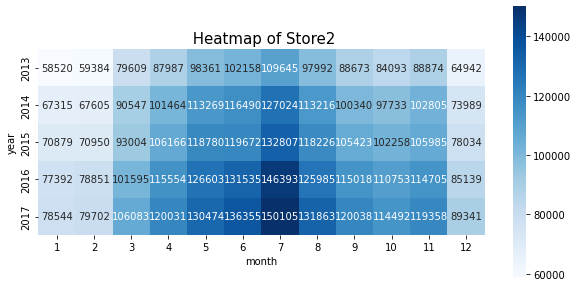

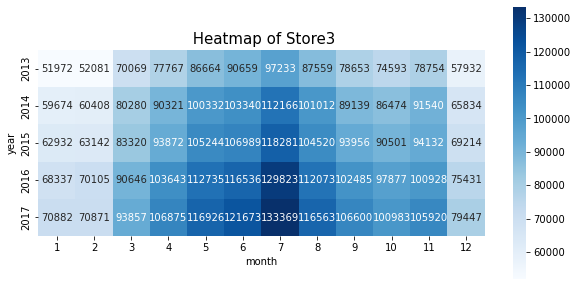

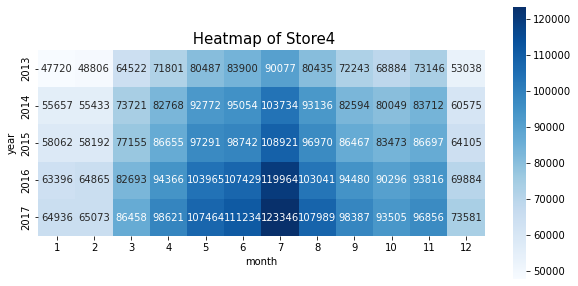

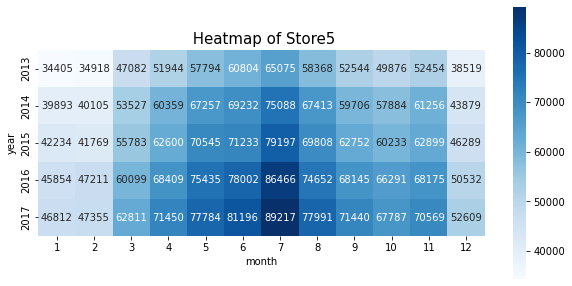

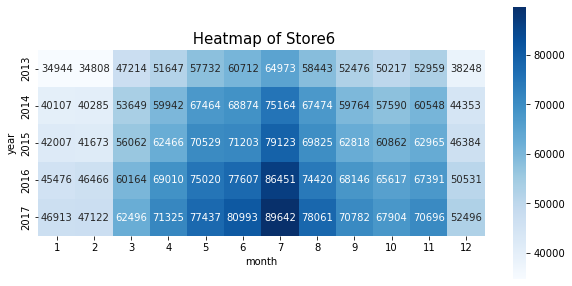

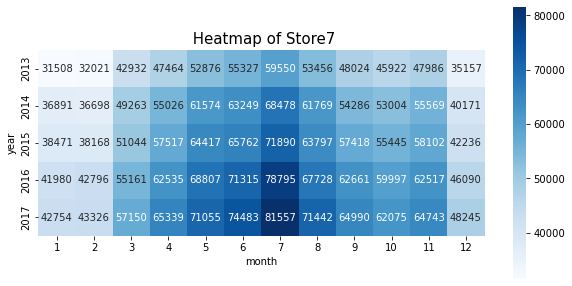

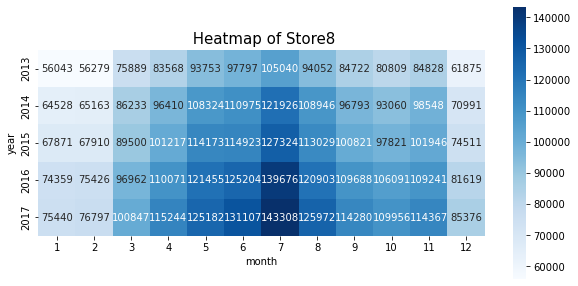

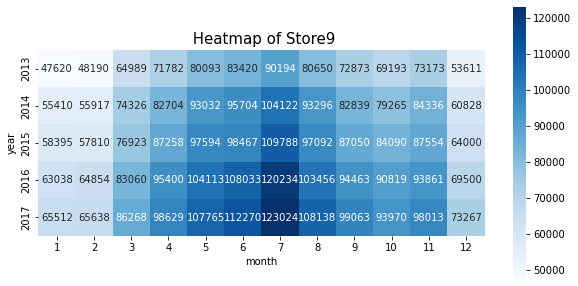

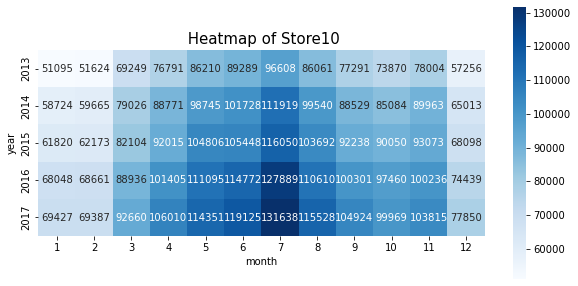

In [24]:
for i in df['store'].unique():
    store_value=df[df['store']==i]
    plt.figure(figsize=(10,5))
    heatmap_sales=pd.pivot_table(data=store_value,values='sales', index ='year',columns =['month'],aggfunc = np.sum)
    sns.heatmap(heatmap_sales,annot=True,fmt='g',cmap ='Blues',square = True, cbar = True)
    plt.title(' Heatmap of Store'+ str(i), fontsize = 15)
    plt.show()
    


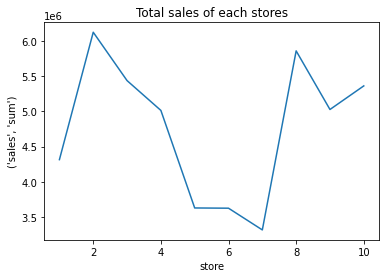

In [25]:
sns.lineplot(data=store_wise_sale,x='store',y=('sales',    'sum'))
plt.title("Total sales of each stores")
plt.show()

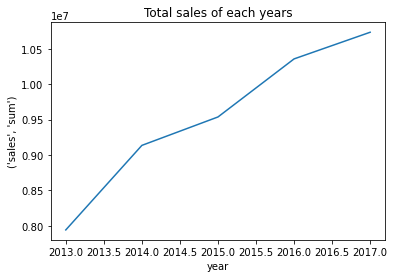

In [26]:
sns.lineplot(data=year_wise_sale,x='year',y=('sales',    'sum'))
plt.title("Total sales of each years")
plt.show()

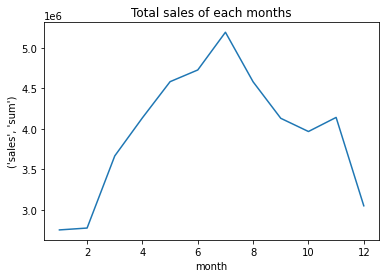

In [27]:
sns.lineplot(data=month_wise_sale,x='month',y=('sales',    'sum'))
plt.title("Total sales of each months")
plt.show()

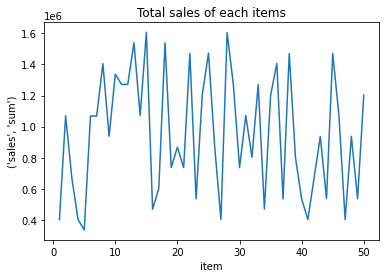

In [28]:
sns.lineplot(data=item_wise_sale,x='item',y=('sales',    'sum'))
plt.title("Total sales of each items")
plt.show()

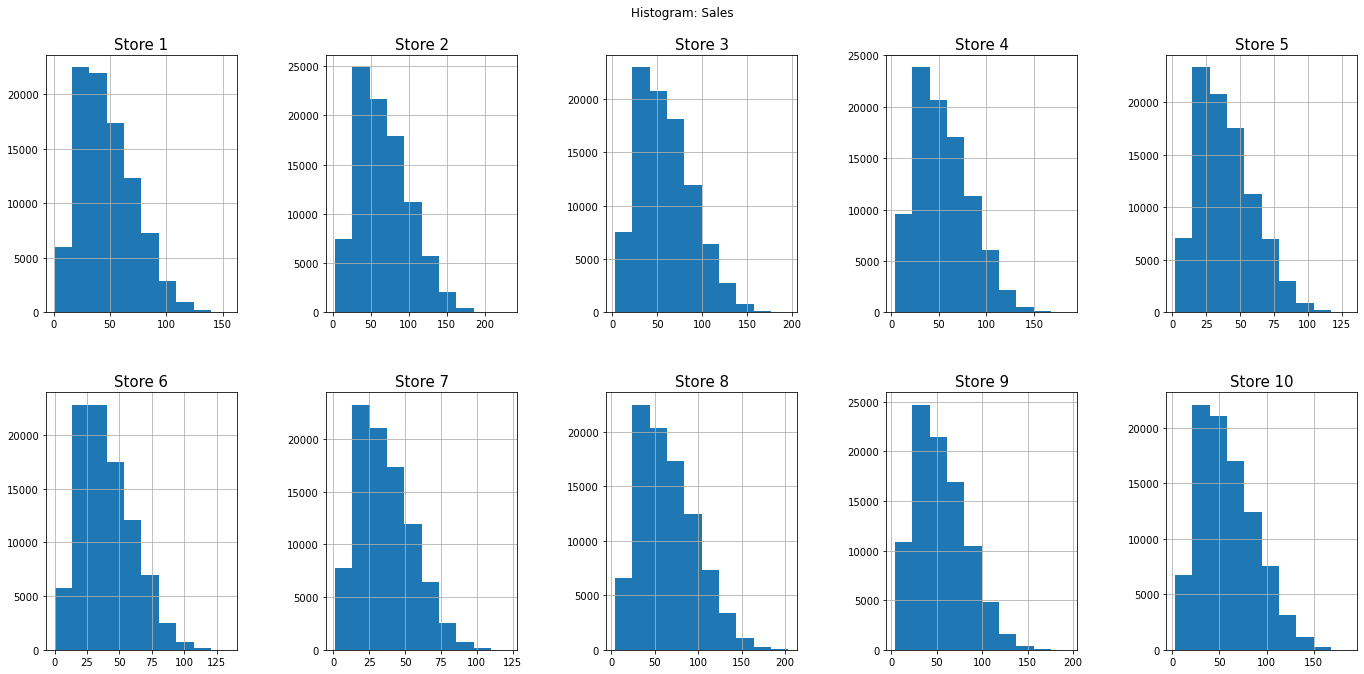

In [29]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
for i in range(1,11):
    if i < 6:
        df[df.store == i].sales.hist(ax=axes[0, i-1])
        axes[0,i-1].set_title("Store " + str(i), fontsize = 15)
        
    else:
        df[df.store == i].sales.hist(ax=axes[1, i - 6])
        axes[1,i-6].set_title("Store " + str(i), fontsize = 15)
plt.tight_layout(pad=4.5)
plt.suptitle("Histogram: Sales");

Boxplots on sales of each stores

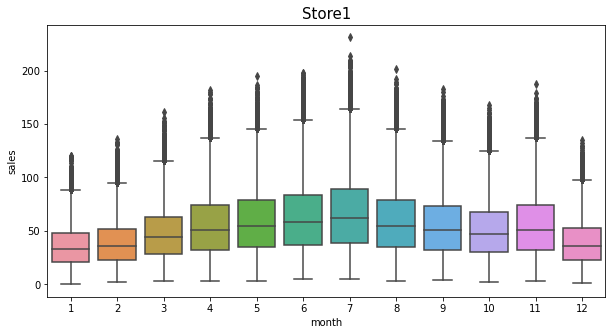

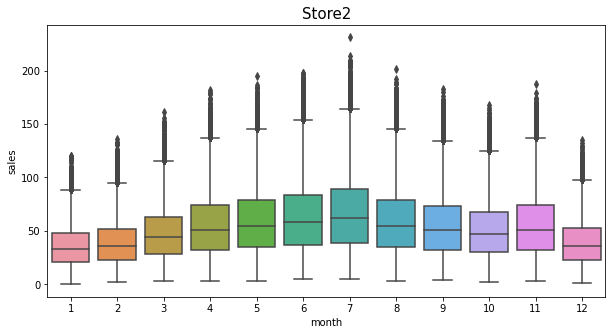

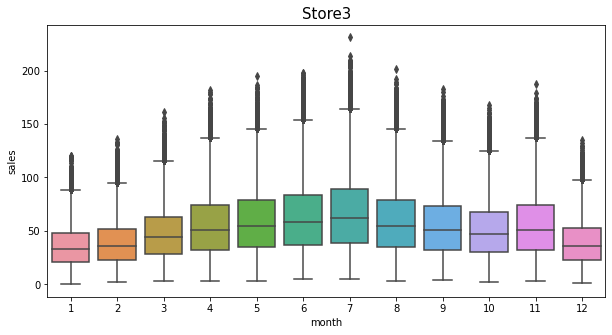

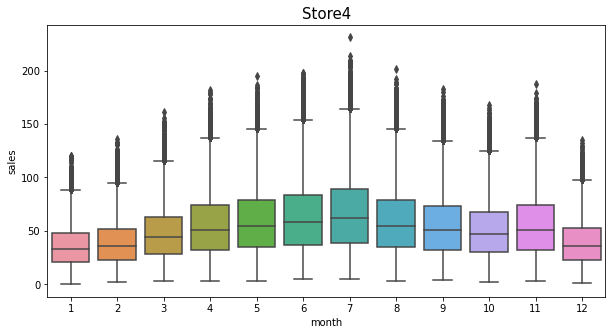

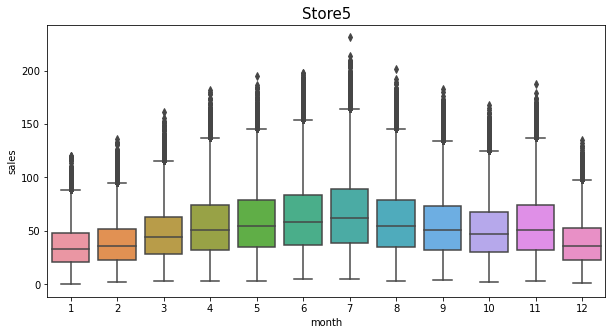

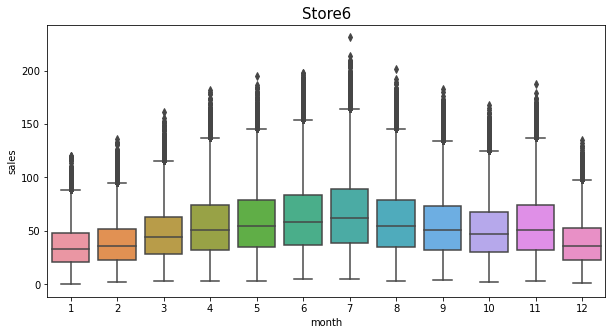

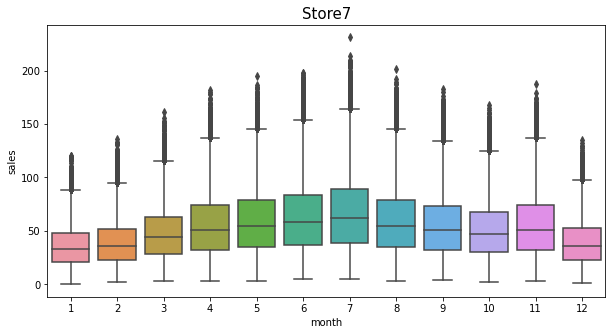

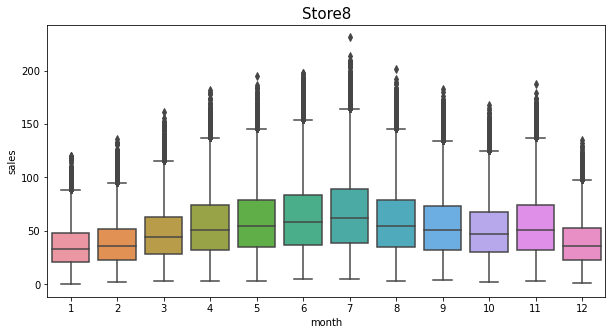

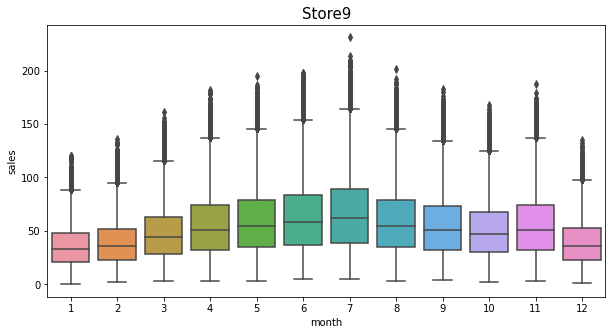

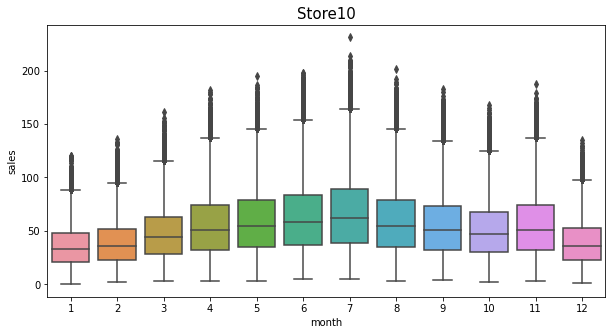

In [30]:
for i in df['store'].unique():
    store_value=df[df['store']==i]
    plt.figure(figsize=(10,5))
    sns.boxplot(x='month',y='sales',data=df)
    plt.title('Store'+ str(i), fontsize = 15)
    plt.show()

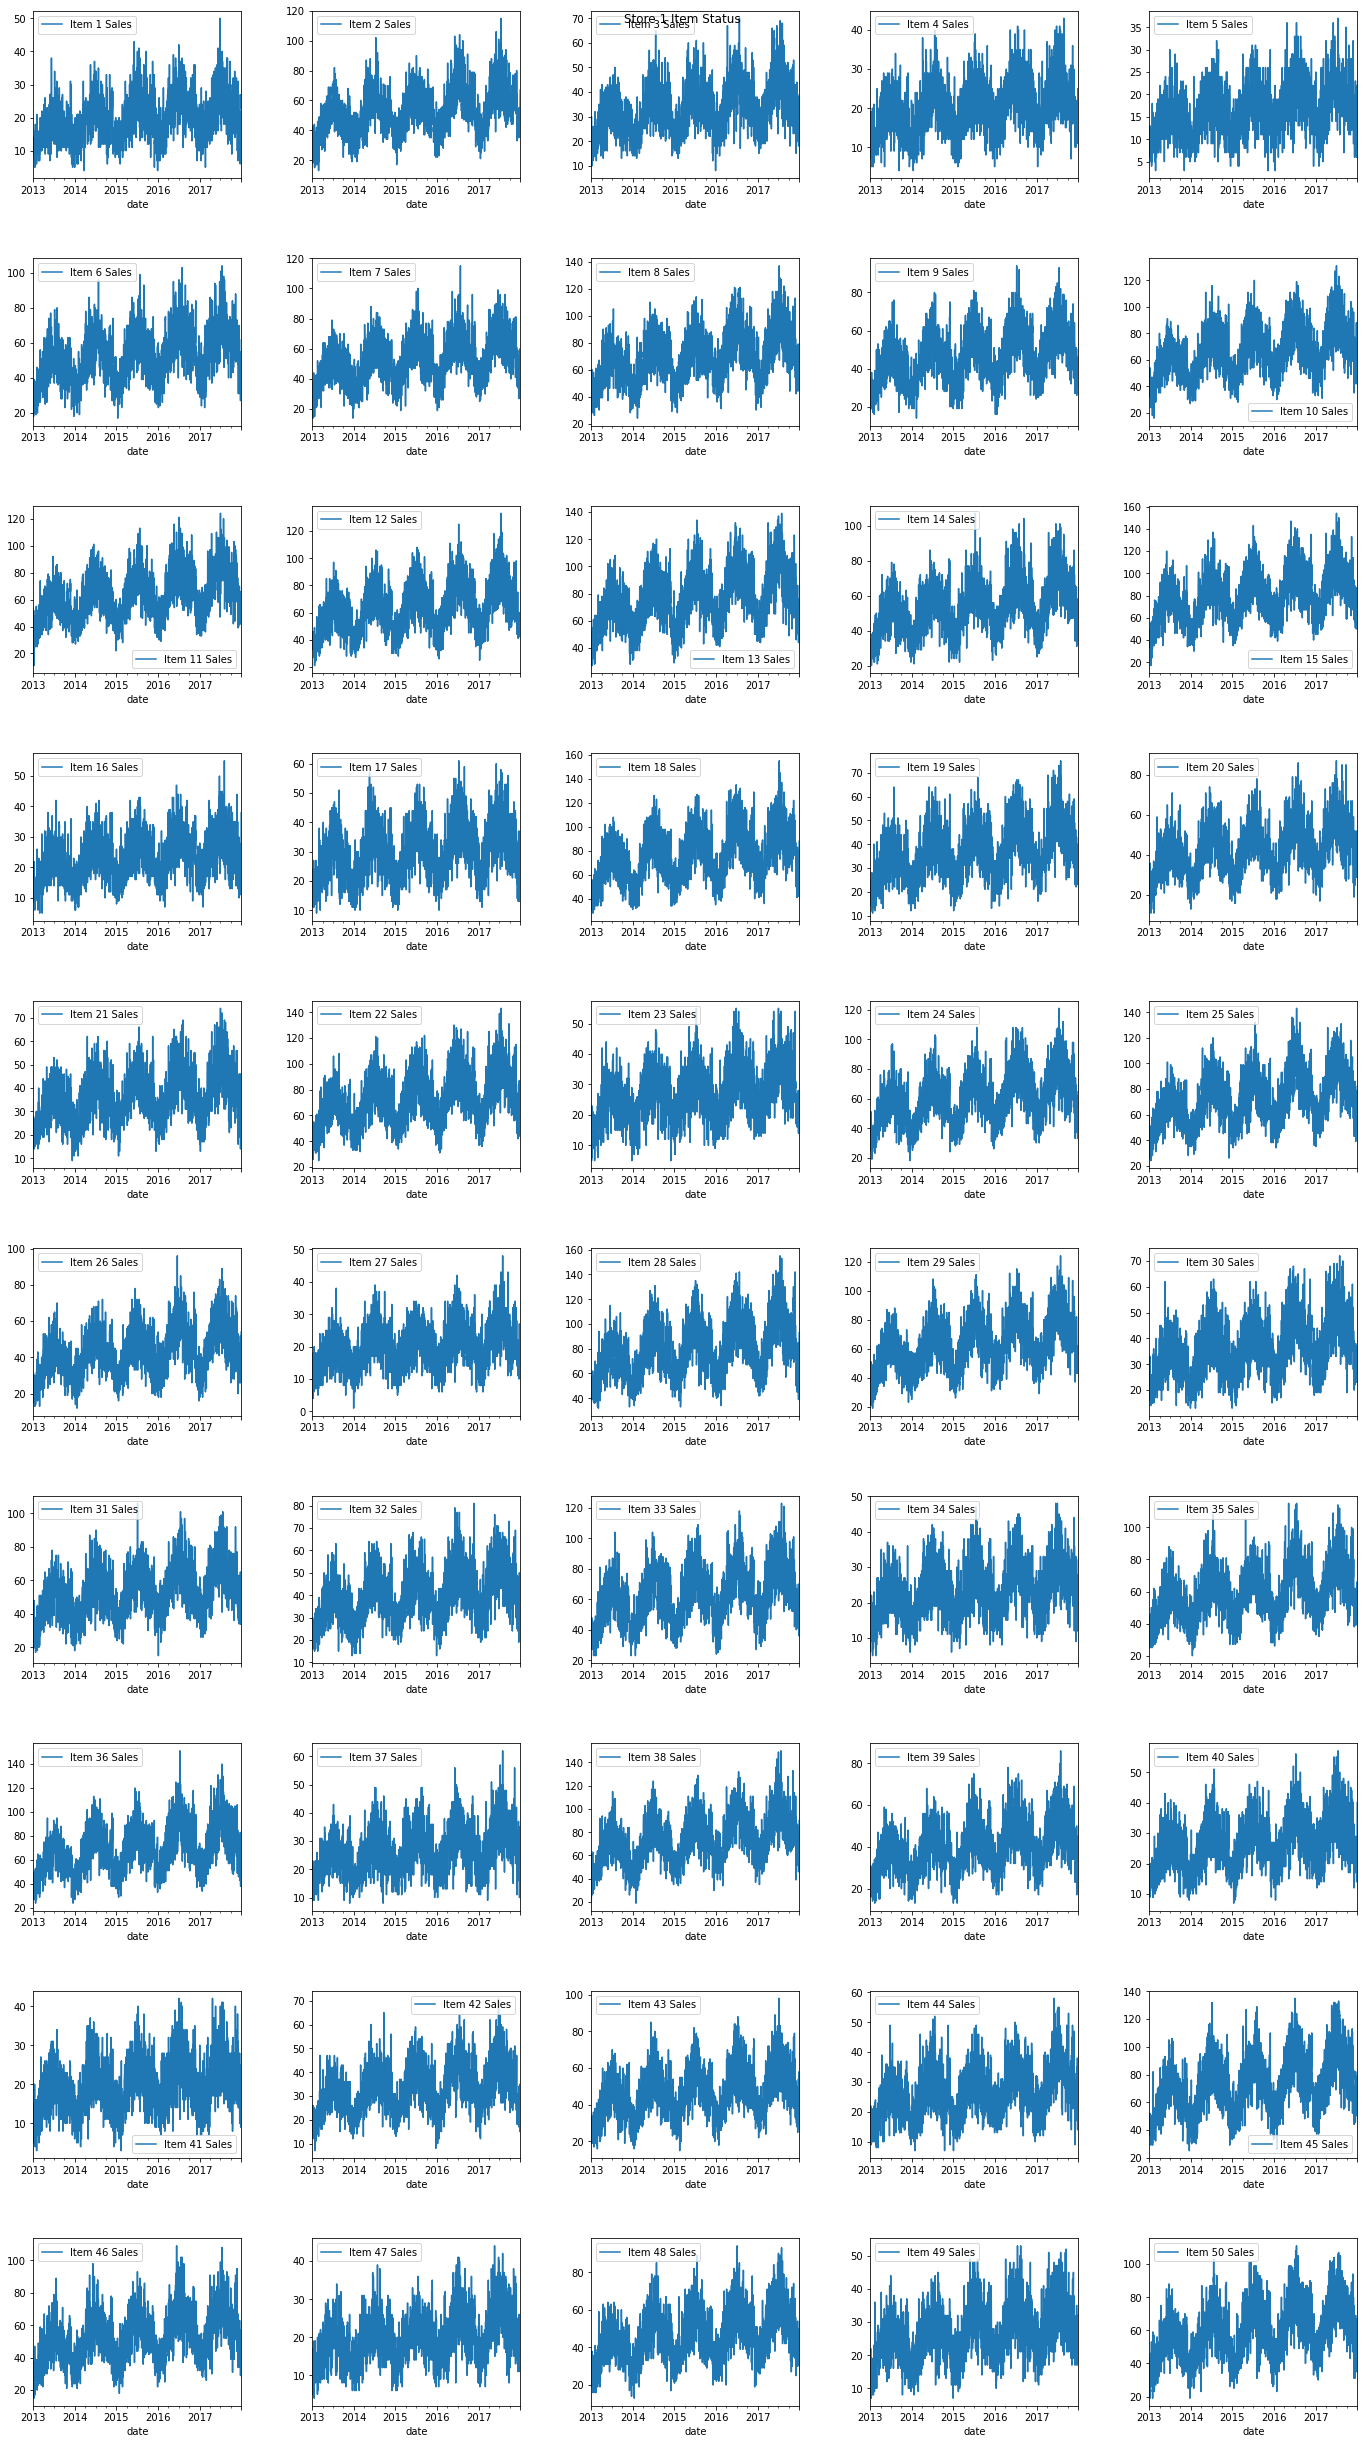

In [31]:
store = 1
sub = df[df.store == store].set_index("date")

fig, axes = plt.subplots(10, 5, figsize=(20, 35))
for i in range(1,51):
    if i < 6:
        sub[sub.item == i].sales.plot(ax=axes[0, i-1], legend=True, label = "Item "+str(i)+" Sales")
    if i >= 6 and i<11:
        sub[sub.item == i].sales.plot(ax=axes[1, i - 6], legend=True, label = "Item "+str(i)+" Sales")
    if i >= 11 and i<16:
        sub[sub.item == i].sales.plot(ax=axes[2, i - 11], legend=True, label = "Item "+str(i)+" Sales")    
    if i >= 16 and i<21:
        sub[sub.item == i].sales.plot(ax=axes[3, i - 16], legend=True, label = "Item "+str(i)+" Sales")    
    if i >= 21 and i<26:
        sub[sub.item == i].sales.plot(ax=axes[4, i - 21], legend=True, label = "Item "+str(i)+" Sales")  
    if i >= 26 and i<31:
        sub[sub.item == i].sales.plot(ax=axes[5, i - 26], legend=True, label = "Item "+str(i)+" Sales")    
    if i >= 31 and i<36:
        sub[sub.item == i].sales.plot(ax=axes[6, i - 31], legend=True, label = "Item "+str(i)+" Sales")    
    if i >= 36 and i<41:
        sub[sub.item == i].sales.plot(ax=axes[7, i - 36], legend=True, label = "Item "+str(i)+" Sales")    
    if i >= 41 and i<46:
        sub[sub.item == i].sales.plot(ax=axes[8, i - 41], legend=True, label = "Item "+str(i)+" Sales") 
    if i >= 46 and i<51:
        sub[sub.item == i].sales.plot(ax=axes[9, i - 46], legend=True, label = "Item "+str(i)+" Sales") 
plt.tight_layout(pad=4.5)
plt.suptitle("Store 1 Item Status");

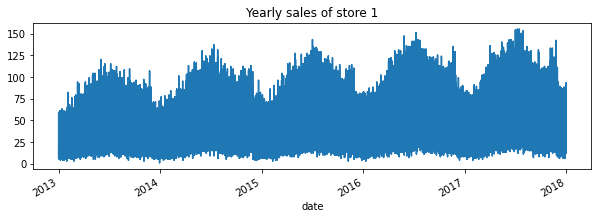

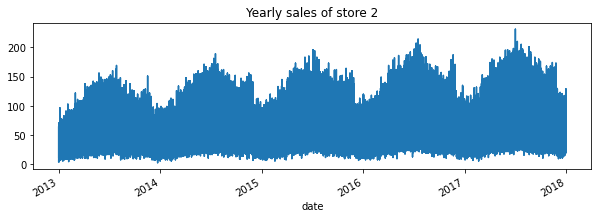

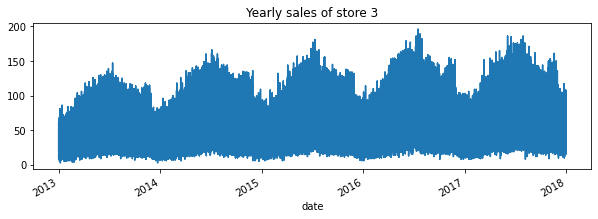

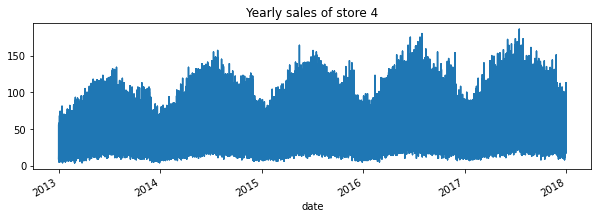

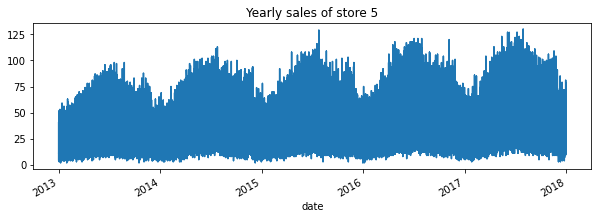

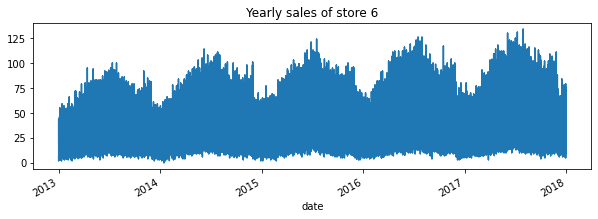

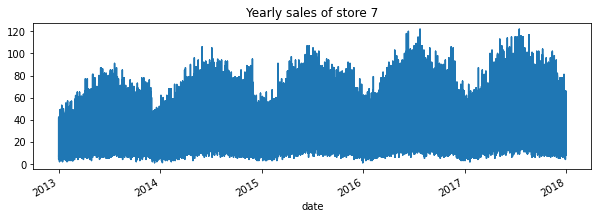

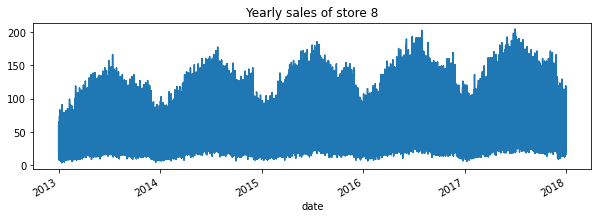

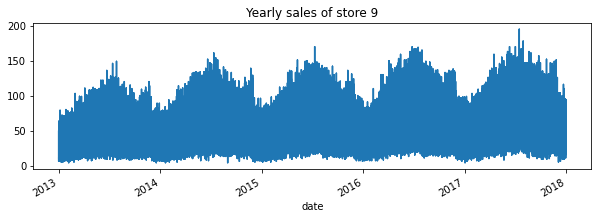

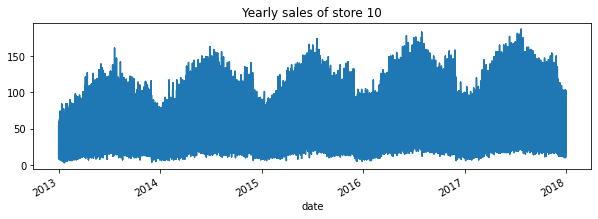

In [32]:
for i in df['store'].unique():
    store_i=df.loc[df['store']==i]
    store_i=store_i.sort_values('date')
    store_i=store_i.set_index('date')
    store_i.sales.plot(figsize=(10,3))
    plt.title("Yearly sales of store "+str(i))
    plt.show()

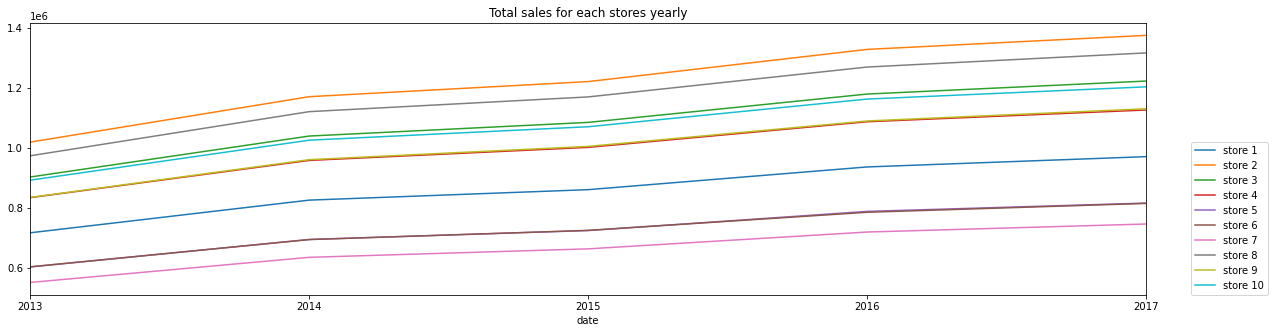

In [33]:
plt.title("Total sales for each stores yearly")
for i in df['store'].unique():
    store_i = df.loc[df['store'] == i]
    store_i = store_i.groupby('date')['sales'].sum().reset_index()
    store_i = store_i.set_index('date')
    store_i = store_i['sales'].resample('Y').sum()    #MS-month start
    store_i.plot(figsize=(20,5))
    plt.legend(('store 1','store 2','store 3','store 4','store 5','store 6','store 7','store 8','store 9','store 10'),loc=(1.04, 0))
    

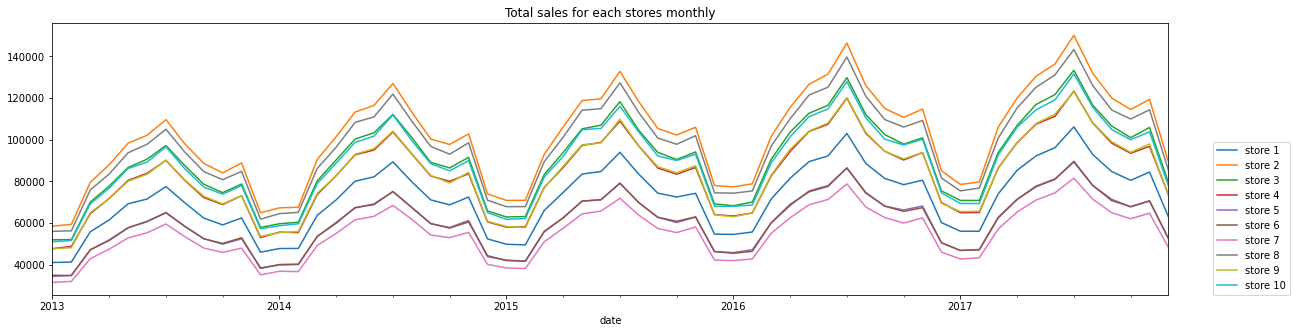

In [34]:
plt.title("Total sales for each stores monthly")
for i in df['store'].unique():
    store_i = df.loc[df['store'] == i]
    store_i = store_i.groupby('date')['sales'].sum().reset_index()
    store_i = store_i.set_index('date')
    store_i = store_i['sales'].resample('M').sum()    #MS-month start
    store_i.plot(figsize=(20,5))
    plt.legend(('store 1','store 2','store 3','store 4','store 5','store 6','store 7','store 8','store 9','store 10'),loc=(1.04, 0))
    

    

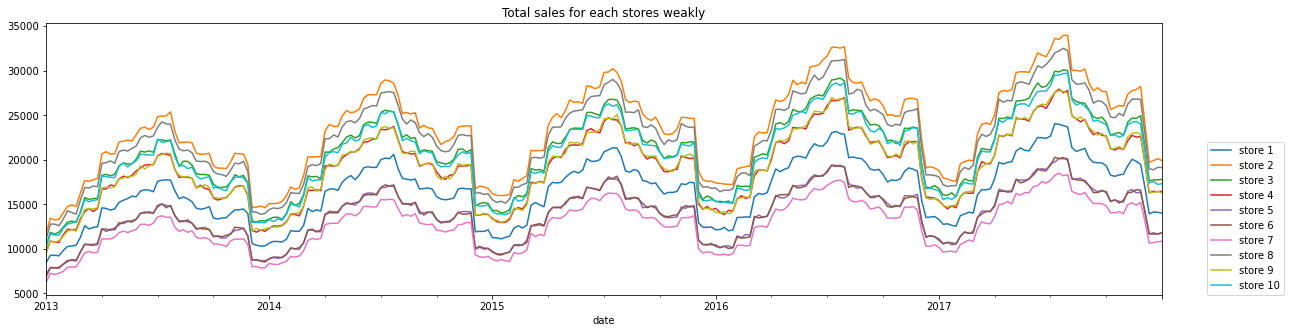

In [35]:
plt.title("Total sales for each stores weakly")
for i in df['store'].unique():
    store_i = df.loc[df['store'] == i]
    store_i = store_i.groupby('date')['sales'].sum().reset_index()
    store_i = store_i.set_index('date')
    store_i = store_i['sales'].resample('W').sum()    
    store_i.plot(figsize=(20,5))
    plt.legend(('store 1','store 2','store 3','store 4','store 5','store 6','store 7','store 8','store 9','store 10'),loc=(1.04, 0))
    

    

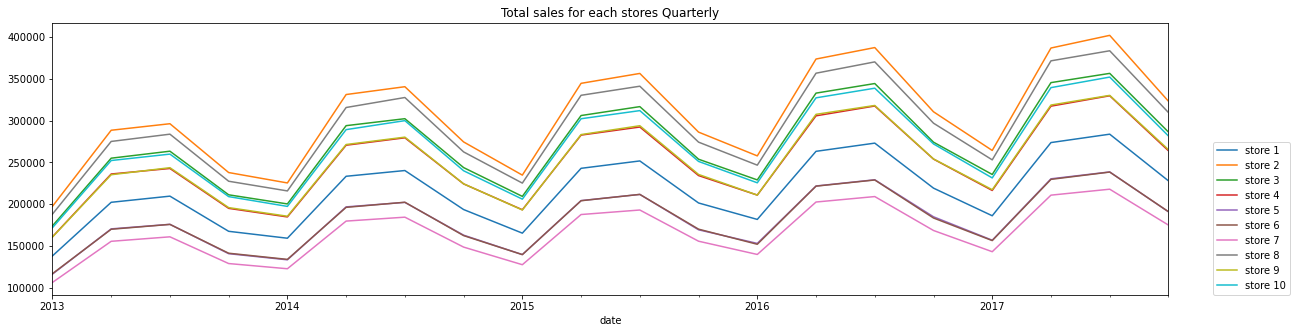

In [36]:
plt.title("Total sales for each stores Quarterly")
for i in df['store'].unique():
    store_i = df.loc[df['store'] == i]
    store_i = store_i.groupby('date')['sales'].sum().reset_index()
    store_i = store_i.set_index('date')
    store_i = store_i['sales'].resample('Q').sum()    
    store_i.plot(figsize=(20,5))
    plt.legend(('store 1','store 2','store 3','store 4','store 5','store 6','store 7','store 8','store 9','store 10'),loc=(1.04, 0))
    

    

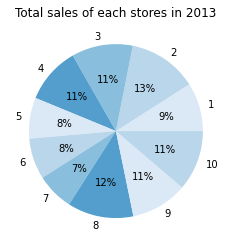

In [37]:

A = df[df['year'] == 2013]

labels = A.groupby('store')['sales'].sum().index
values = A.groupby('store')['sales'].sum().values

plt.pie(values, labels = labels,colors = sns.color_palette("Blues")[0:4] , autopct='%.0f%%')
plt.title("Total sales of each stores in 2013")
plt.show()

<AxesSubplot:title={'center':'Year wise sales'}, ylabel='year'>

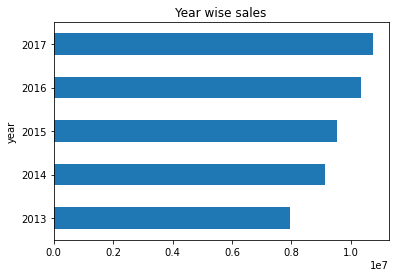

In [38]:
df.groupby('year')['sales'].sum().plot(kind='barh',title='Year wise sales')

### ETS decomposition

In [39]:
#ETS stands for Error-Trend-Seasonality and is a model used for the time series decomposition. 
#It decomposes the series into the error, trend and seasonality component.
#It focuses on trend and seasonal components.

from pylab import rcParams
import statsmodels.api as sm

>Yearly decomposition of stores (additive)

----------------------------------------------------------------------------------------------
ETS decomposition of store_1


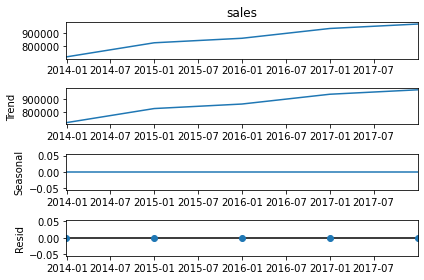

----------------------------------------------------------------------------------------------
ETS decomposition of store_2


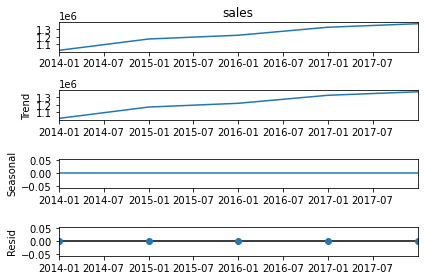

----------------------------------------------------------------------------------------------
ETS decomposition of store_3


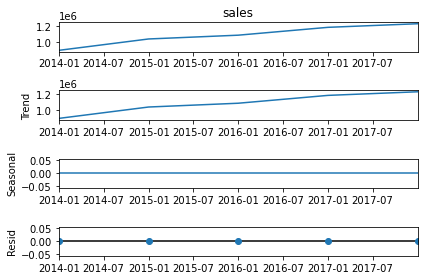

----------------------------------------------------------------------------------------------
ETS decomposition of store_4


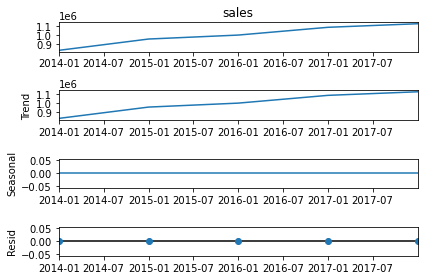

----------------------------------------------------------------------------------------------
ETS decomposition of store_5


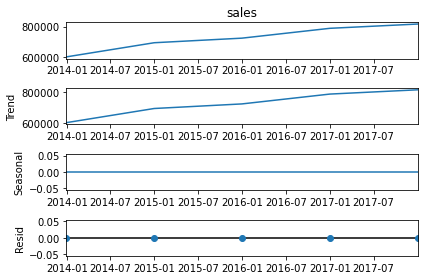

----------------------------------------------------------------------------------------------
ETS decomposition of store_6


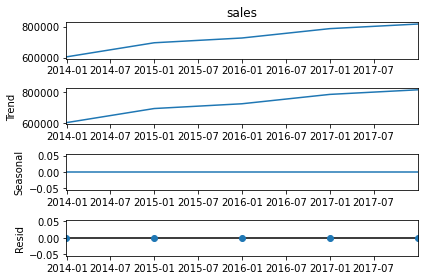

----------------------------------------------------------------------------------------------
ETS decomposition of store_7


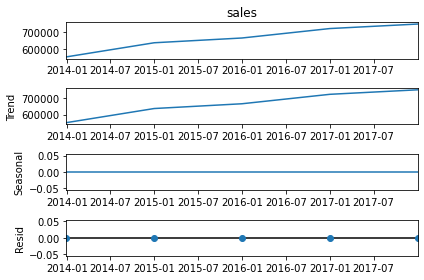

----------------------------------------------------------------------------------------------
ETS decomposition of store_8


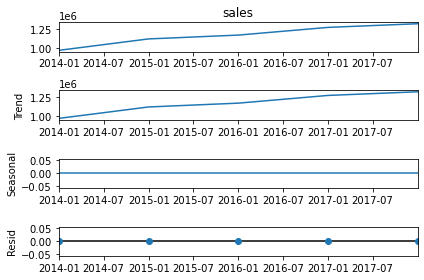

----------------------------------------------------------------------------------------------
ETS decomposition of store_9


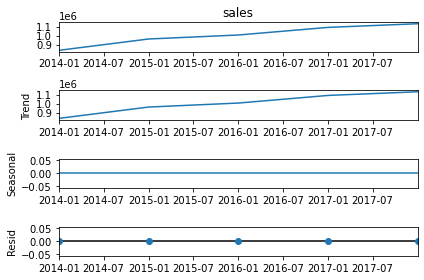

----------------------------------------------------------------------------------------------
ETS decomposition of store_10


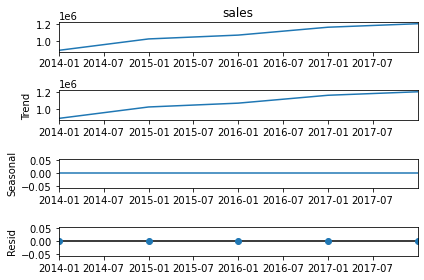

In [40]:
for i in df['store'].unique():
    store_i = df.loc[df['store'] == i]
    store_i = store_i.groupby('date')['sales'].sum().reset_index()
    store_i = store_i.set_index('date')
    store_i = store_i['sales'].resample('Y').sum()
    decomposition_store_i = sm.tsa.seasonal_decompose(store_i,model='additive')
    fig = decomposition_store_i.plot()
    print('----------------------------------------------------------------------------------------------')
    print('ETS decomposition of store_'+str(i))
    plt.show()

>Monthly decomposition of stores (additive)

----------------------------------------------------------------------------------------------
ETS decomposition of store_1


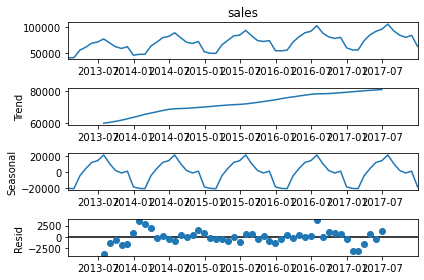

----------------------------------------------------------------------------------------------
ETS decomposition of store_2


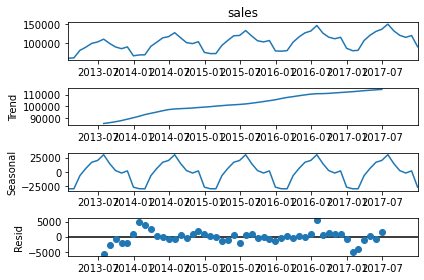

----------------------------------------------------------------------------------------------
ETS decomposition of store_3


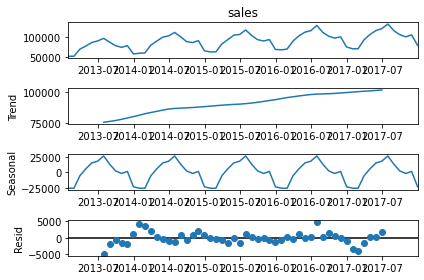

----------------------------------------------------------------------------------------------
ETS decomposition of store_4


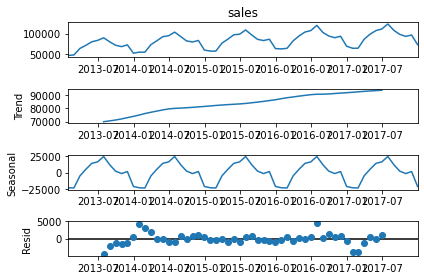

----------------------------------------------------------------------------------------------
ETS decomposition of store_5


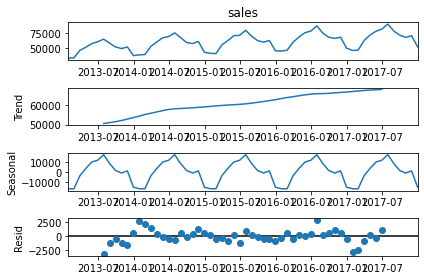

----------------------------------------------------------------------------------------------
ETS decomposition of store_6


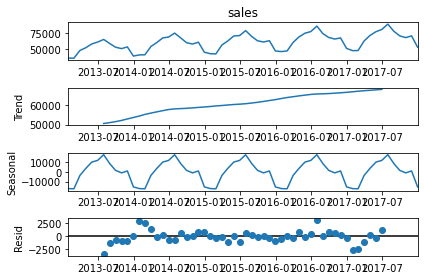

----------------------------------------------------------------------------------------------
ETS decomposition of store_7


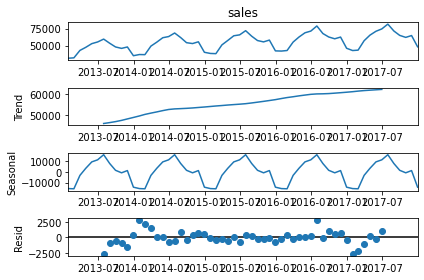

----------------------------------------------------------------------------------------------
ETS decomposition of store_8


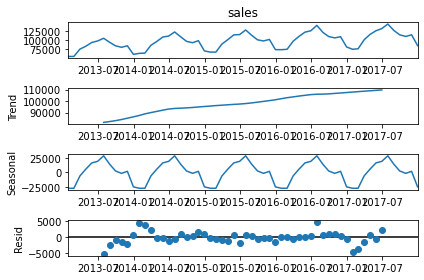

----------------------------------------------------------------------------------------------
ETS decomposition of store_9


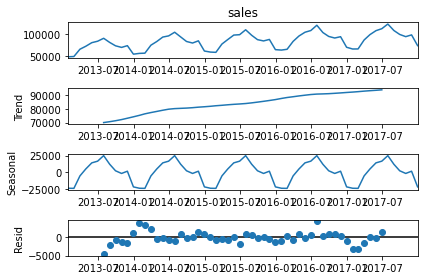

----------------------------------------------------------------------------------------------
ETS decomposition of store_10


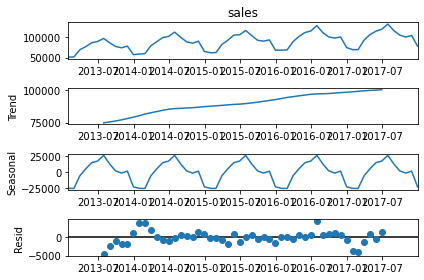

In [41]:
for i in df['store'].unique():
    store_i = df.loc[df['store'] == i]
    store_i = store_i.groupby('date')['sales'].sum().reset_index()
    store_i = store_i.set_index('date')
    store_i = store_i['sales'].resample('M').sum()
    decomposition_store_i = sm.tsa.seasonal_decompose(store_i,model='additive')
    fig = decomposition_store_i.plot()
    print('----------------------------------------------------------------------------------------------')
    print('ETS decomposition of store_'+str(i))
    plt.show()

>Monthly decomposiion of stores (multiplicative)

----------------------------------------------------------------------------------------------
ETS decomposition of store_1


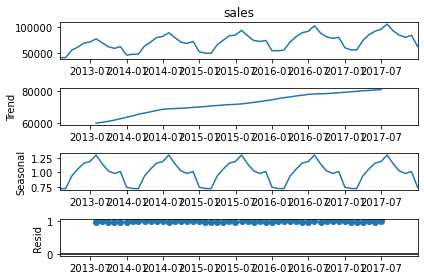

----------------------------------------------------------------------------------------------
ETS decomposition of store_2


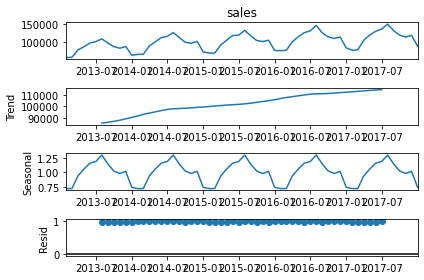

----------------------------------------------------------------------------------------------
ETS decomposition of store_3


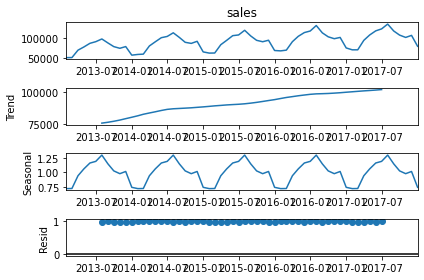

----------------------------------------------------------------------------------------------
ETS decomposition of store_4


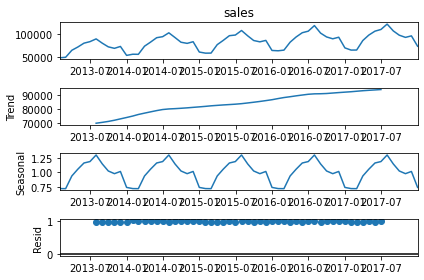

----------------------------------------------------------------------------------------------
ETS decomposition of store_5


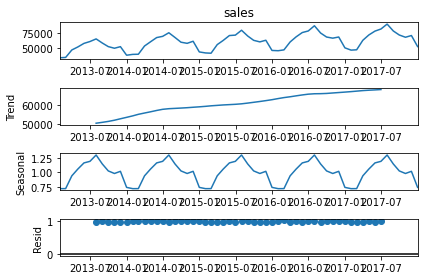

----------------------------------------------------------------------------------------------
ETS decomposition of store_6


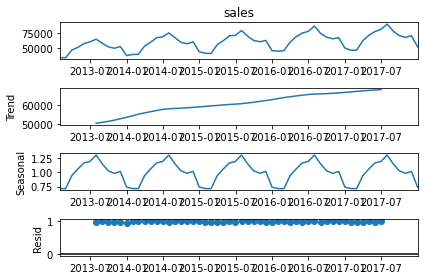

----------------------------------------------------------------------------------------------
ETS decomposition of store_7


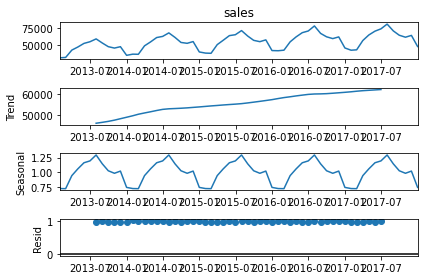

----------------------------------------------------------------------------------------------
ETS decomposition of store_8


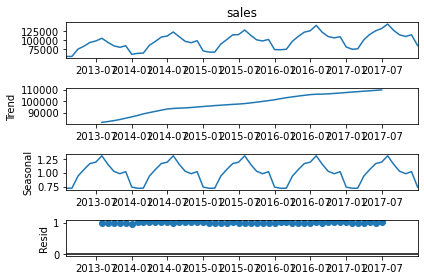

----------------------------------------------------------------------------------------------
ETS decomposition of store_9


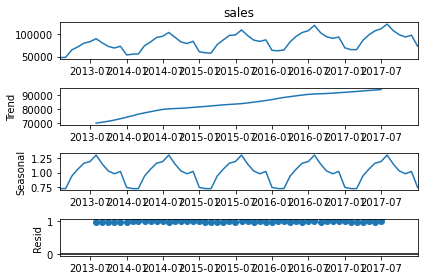

----------------------------------------------------------------------------------------------
ETS decomposition of store_10


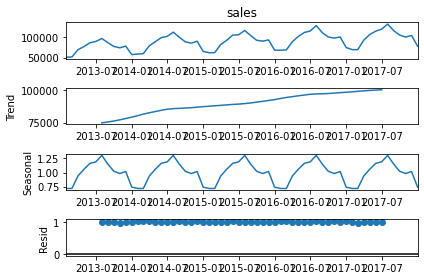

In [42]:
for i in df['store'].unique():
    store_i = df.loc[df['store'] == i]
    store_i = store_i.groupby('date')['sales'].sum().reset_index()
    store_i = store_i.set_index('date')
    store_i = store_i['sales'].resample('M').sum()
    decomposition_store_i = sm.tsa.seasonal_decompose(store_i,model='multiplicative')
    fig = decomposition_store_i.plot()
    print('----------------------------------------------------------------------------------------------')
    print('ETS decomposition of store_'+str(i))
    plt.show()

Trend : The data generally tends to increase or decrease over long period of time is called having some trend. 

Seasonality : Seasonal variations in the time series occur due to the factors which operate in a regular and periodic manner over a span of less than a year and have the same pattern year after year. 

>Monthly trend and seasonality

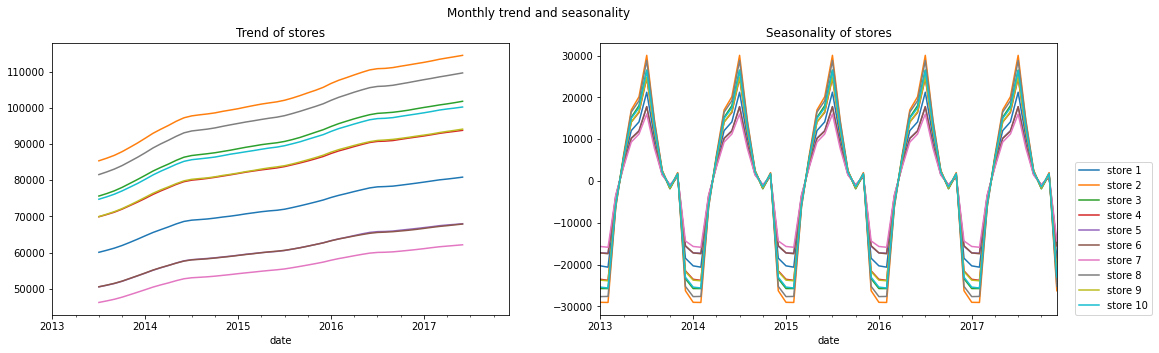

In [43]:
ax1 = plt.subplot(1,2,1)
plt.title('Trend of stores')
for i in df['store'].unique():
    store_i = df.loc[df['store'] == i]
    store_i = store_i.groupby('date')['sales'].sum().reset_index()
    store_i = store_i.set_index('date')
    store_i = store_i['sales'].resample('M').sum()
    decomposition_store_i = sm.tsa.seasonal_decompose(store_i,model='additive')
    decomposition_store_i.trend.plot(figsize=(18,5))
    
ax2= plt.subplot(1,2,2)
plt.title('Seasonality of stores')
for i in df['store'].unique():
    store_i = df.loc[df['store'] == i]
    store_i = store_i.groupby('date')['sales'].sum().reset_index()
    store_i = store_i.set_index('date')
    store_i = store_i['sales'].resample('M').sum()
    decomposition_store_i = sm.tsa.seasonal_decompose(store_i,model='additive')
    decomposition_store_i.seasonal.plot(figsize=(18,5))
    plt.legend(('store 1','store 2','store 3','store 4','store 5','store 6','store 7','store 8','store 9','store 10'),loc=(1.04, 0))
    
plt.suptitle("Monthly trend and seasonality");    

>Yearly trent and seasonality

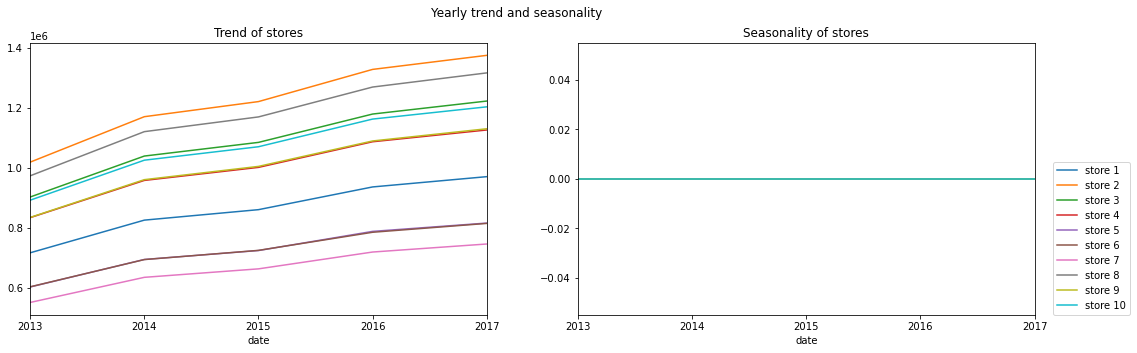

In [44]:
ax1 = plt.subplot(1,2,1)
plt.title('Trend of stores')
for i in df['store'].unique():
    store_i = df.loc[df['store'] == i]
    store_i = store_i.groupby('date')['sales'].sum().reset_index()
    store_i = store_i.set_index('date')
    store_i = store_i['sales'].resample('Y').sum()
    decomposition_store_i = sm.tsa.seasonal_decompose(store_i,model='additive')
    decomposition_store_i.trend.plot(figsize=(18,5))
    
ax2= plt.subplot(1,2,2)
plt.title('Seasonality of stores')
for i in df['store'].unique():
    store_i = df.loc[df['store'] == i]
    store_i = store_i.groupby('date')['sales'].sum().reset_index()
    store_i = store_i.set_index('date')
    store_i = store_i['sales'].resample('Y').sum()
    decomposition_store_i = sm.tsa.seasonal_decompose(store_i,model='additive')
    decomposition_store_i.seasonal.plot(figsize=(18,5))
    plt.legend(('store 1','store 2','store 3','store 4','store 5','store 6','store 7','store 8','store 9','store 10'),loc=(1.04, 0))
    
plt.suptitle("Yearly trend and seasonality");

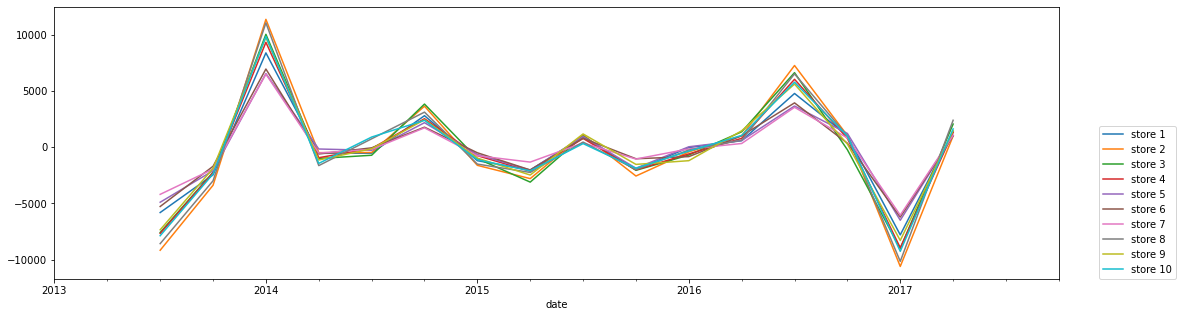

In [45]:
#Noise
plt.title( '')
for i in df['store'].unique():
    store_i = df.loc[df['store'] == i]
    store_i = store_i.groupby('date')['sales'].sum().reset_index()
    store_i = store_i.set_index('date')
    store_i = store_i['sales'].resample('Q').sum()
    decomposition_store_i = sm.tsa.seasonal_decompose(store_i,model='additive')
    decomposition_store_i.resid.plot(figsize=(18,5))
    plt.legend(('store 1','store 2','store 3','store 4','store 5','store 6','store 7','store 8','store 9','store 10'),loc=(1.04, 0))

### Test for stationarity

* Stationarity: stationarity implies the statistical properties of a time series do not change over time.
* A time series is said to be “stationary” if it has no trend, exhibits constant variance over time, and has a constant autocorrelation structure over time.
* H0: The time series is non-stationary. In other words, it has some time-dependent structure and does not have constant variance over time.
* HA: The time series is stationary.
* If the p-value from the test is less than some significance level (e.g. α = .05), then we can reject the null hypothesis and conclude that the time series is stationary.

In [46]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        

        print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

>Yearly stationarity of stores

In [47]:
for i in df['store'].unique():
    store_i = df.loc[df['store'] == i]
    store_i = store_i.groupby('date')['sales'].sum().reset_index()
    store_i = store_i.set_index('date')
    store_i = store_i['sales'].resample('Y').sum()
    print('Stationarity of store_'+str(i))
    print('')
    adf_test(store_i)
    print('----------------------------------------------------------------------------------------------')
    

Stationarity of store_1

Augmented Dickey-Fuller Test: 
ADF test statistic    -1.802431
p-value                0.379255
# lags used            0.000000
# observations         4.000000
critical value (1%)   -7.355441
ADF test statistic    -1.802431
p-value                0.379255
# lags used            0.000000
# observations         4.000000
critical value (1%)   -7.355441
critical value (5%)   -4.474365
ADF test statistic     -1.802431
p-value                 0.379255
# lags used             0.000000
# observations          4.000000
critical value (1%)    -7.355441
critical value (5%)    -4.474365
critical value (10%)   -3.126933
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
----------------------------------------------------------------------------------------------
Stationarity of store_2

Augmented Dickey-Fuller Test: 
ADF test statistic    -1.807695
p-value                0.376648
# lags used            0.0

>Quarterly stationarity of stores

In [48]:
for i in df['store'].unique():
    store_i = df.loc[df['store'] == i]
    store_i = store_i.groupby('date')['sales'].sum().reset_index()
    store_i = store_i.set_index('date')
    store_i = store_i['sales'].resample('Q').sum()
    print('Stationarity of store_'+str(i))
    print('')
    adf_test(store_i)
    print('----------------------------------------------------------------------------------------------')
    

Stationarity of store_1

Augmented Dickey-Fuller Test: 
ADF test statistic    -7.125466e+00
p-value                3.629962e-10
# lags used            7.000000e+00
# observations         1.200000e+01
critical value (1%)   -4.137829e+00
ADF test statistic    -7.125466e+00
p-value                3.629962e-10
# lags used            7.000000e+00
# observations         1.200000e+01
critical value (1%)   -4.137829e+00
critical value (5%)   -3.154972e+00
ADF test statistic     -7.125466e+00
p-value                 3.629962e-10
# lags used             7.000000e+00
# observations          1.200000e+01
critical value (1%)    -4.137829e+00
critical value (5%)    -3.154972e+00
critical value (10%)   -2.714477e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
----------------------------------------------------------------------------------------------
Stationarity of store_2

Augmented Dickey-Fuller Test: 
ADF test statistic    -5.90

>Monthly stationarity of stores

In [49]:
for i in df['store'].unique():
    store_i = df.loc[df['store'] == i]
    store_i = store_i.groupby('date')['sales'].sum().reset_index()
    store_i = store_i.set_index('date')
    store_i = store_i['sales'].resample('M').sum()
    print('Stationarity of store_'+str(i))
    print('')
    adf_test(store_i)
    print('----------------------------------------------------------------------------------------------')
    

Stationarity of store_1

Augmented Dickey-Fuller Test: 
ADF test statistic     -4.995500
p-value                 0.000023
# lags used            11.000000
# observations         48.000000
critical value (1%)    -3.574589
ADF test statistic     -4.995500
p-value                 0.000023
# lags used            11.000000
# observations         48.000000
critical value (1%)    -3.574589
critical value (5%)    -2.923954
ADF test statistic      -4.995500
p-value                  0.000023
# lags used             11.000000
# observations          48.000000
critical value (1%)     -3.574589
critical value (5%)     -2.923954
critical value (10%)    -2.600039
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
----------------------------------------------------------------------------------------------
Stationarity of store_2

Augmented Dickey-Fuller Test: 
ADF test statistic     -4.895429
p-value                 0.000036
# lags used    

* Yearly- every stores are non stationary
* Quarterly- every stores except store 3 are non stationary
* Monthly- every stores are stationary

### Rolling Statistics Test

This method gave a visual representation of the data to define its stationarity. A Moving variance or moving average graph is plot and then it is observed whether it varies with time or not. 
In this method, a moving window of time is taken (based on our needs, for eg-10, 12, etc.) and then the mean of that time period is calculated as the current value.

In [50]:
df['date']=pd.to_datetime(df['date'],infer_datetime_format=True)
#df['date'] = pd.to_datetime(df['date'])
index=df.set_index(['date'])

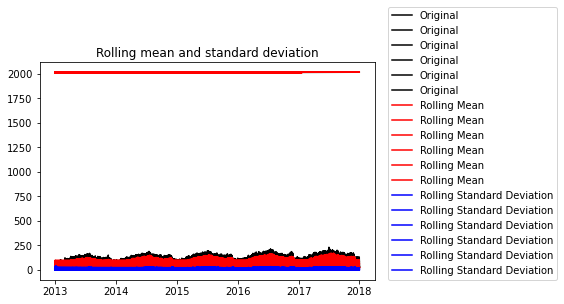

In [51]:

rmean=index.rolling(window=12).mean()
rstd=index.rolling(window=12).std()
#print(rmean,rstd)

plt.plot(index , color='black',label='Original')
plt.plot(rmean , color='red',label='Rolling Mean')
plt.plot(rstd,color='blue',label = 'Rolling Standard Deviation')
plt.legend(loc=(1.04, 0))
plt.title("Rolling mean and standard deviation")
plt.show(block=False)

graph of rolling mean and rolling standard deviation is constant, this shows that our second dataset is stationary

### Kwiatkowski-Phillips-Schmidt-Shin (“KPSS”) test

Null Hypothesis: The process is trend stationary.

Alternate Hypothesis: The series has a unit root (series is not stationary).

If the test statistic is greater than the critical value, we reject the null hypothesis (series is not stationary).

In [52]:
from statsmodels.tsa.stattools import kpss


def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)
    
    if kpsstest[1] >= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is non stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is stationary")    

In [53]:
for i in df['store'].unique():
    store_i = df.loc[df['store'] == i]
    store_i = store_i.groupby('date')['sales'].sum().reset_index()
    store_i = store_i.set_index('date')
    store_i = store_i['sales'].resample('M').sum()
    print('Stationarity of store_'+str(i))
    print('')
    kpss_test(store_i)
    print('----------------------------------------------------------------------------------------------')
    

Stationarity of store_1

Results of KPSS Test:
Test Statistic           0.538538
p-value                  0.032987
Lags Used                4.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is stationary
----------------------------------------------------------------------------------------------
Stationarity of store_2

Results of KPSS Test:
Test Statistic           0.534764
p-value                  0.033837
Lags Used                4.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is stationary
-------------------------------------------------------------------------

In [54]:
kpss_test(df["sales"])

Results of KPSS Test:
Test Statistic             3.881949
p-value                    0.010000
Lags Used                538.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is stationary


C:\Users\Shahma\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


### Auto correlation

In [55]:
#create lagged variables at different timesteps say, t+1, t+2, t+3. 
#Shift function shifts the timestep by a specified value 
#Concat function joins the lagged variables at different timesteps


store_1 = df.loc[df['store'] == 1]
store_1 = store_1.groupby('date')['sales'].sum().reset_index()
store_1 = store_1.set_index('date')
store_1 = store_1['sales'].resample('M').sum()

# using shift function to shift the values.
dataframe = pd.concat([store_1.shift(7),store_1.shift(6),store_1.shift(5),store_1.shift(4),
                       store_1.shift(3), store_1.shift(2),store_1.shift(1), store_1], axis=1)
# naming the columns
dataframe.columns = ['t', 't+1', 't+2', 't+3','t+4','t+5','t+6','t+7']
 
# using corr() function to compute the correlation
result = dataframe.corr().head(1)
 
result

t       t+1       t+2       t+3       t+4       t+5       t+6       t+7
t  1.0  0.800409  0.505039  0.154717 -0.125265 -0.412895 -0.461023 -0.392261

>>> correlogram

A plot of the autocorrelation of a time series by lag is called the AutoCorrelation Function (ACF) or correlogram. 
A correlogram plots the correlation of all possible timesteps. 
The lagged variables with the highest correlation can be considered for modeling. 

---Store 1-------------------------------------------------------------
     t       t+1       t+2       t+3       t+4       t+5       t+6       t+7
t  1.0  0.800409  0.505039  0.154717 -0.125265 -0.412895 -0.461023 -0.392261
---Store 2-------------------------------------------------------------
     t       t+1       t+2       t+3       t+4       t+5       t+6       t+7
t  1.0  0.797984  0.499494  0.152182 -0.123865 -0.412885 -0.464497 -0.394643
---Store 3-------------------------------------------------------------
     t       t+1       t+2       t+3       t+4       t+5       t+6       t+7
t  1.0  0.801441  0.506128  0.156201 -0.122812 -0.412314 -0.461578 -0.389596
---Store 4-------------------------------------------------------------
     t       t+1       t+2      t+3       t+4       t+5       t+6       t+7
t  1.0  0.799603  0.505326  0.15316 -0.125113 -0.415061 -0.465381 -0.396136
---Store 5-------------------------------------------------------------
     t       t+1       t+2

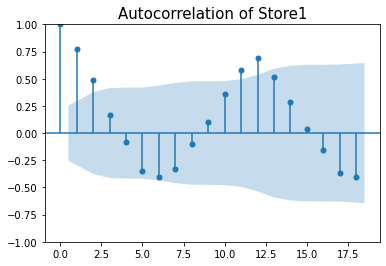

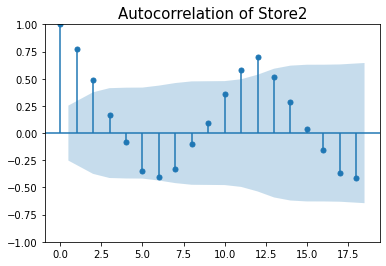

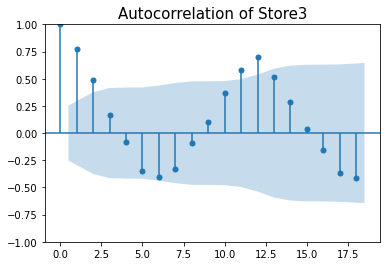

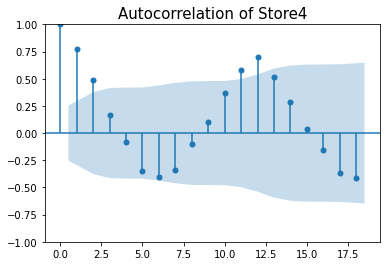

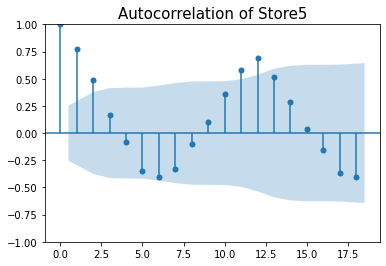

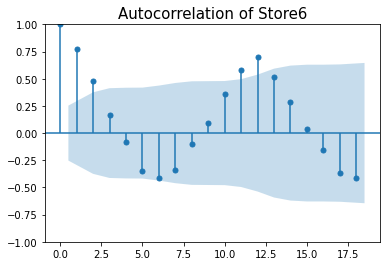

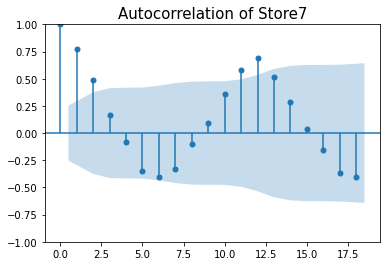

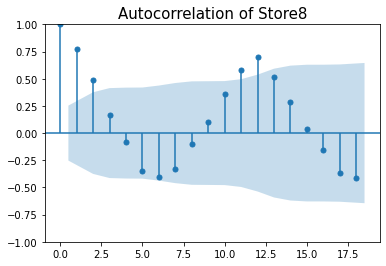

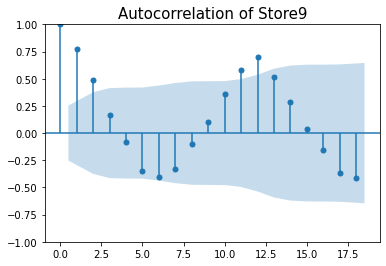

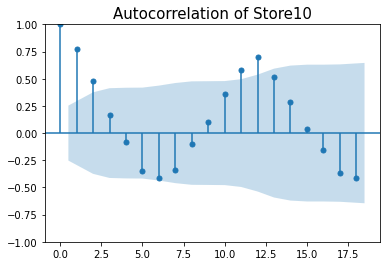

In [56]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

for i in df['store'].unique():
    store_i = df.loc[df['store'] == i]
    store_i = store_i.groupby('date')['sales'].sum().reset_index()
    store_i = store_i.set_index('date')
    store_i = store_i['sales'].resample('M').sum()
    # using shift function to shift the values.
    dataframe_i = pd.concat([store_i.shift(7),store_i.shift(6),store_i.shift(5),store_i.shift(4),
                       store_i.shift(3), store_i.shift(2),store_i.shift(1), store_i], axis=1)
    # naming the columns
    dataframe_i.columns = ['t', 't+1', 't+2', 't+3','t+4','t+5','t+6','t+7']
    # using corr() function to compute the correlation
    result_i = dataframe_i.corr().head(1)
    plot_acf(store_i)
    plt.title('Autocorrelation of Store'+ str(i), fontsize = 15)
    print('---Store '+str(i)+ '-------------------------------------------------------------')
    print(result_i)
    
    

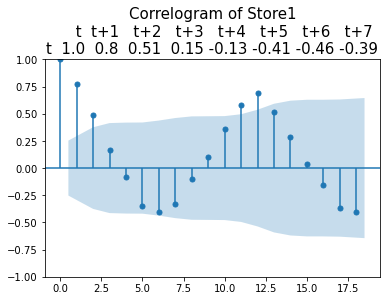

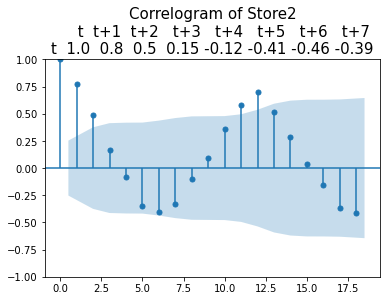

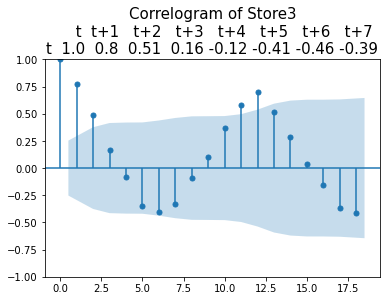

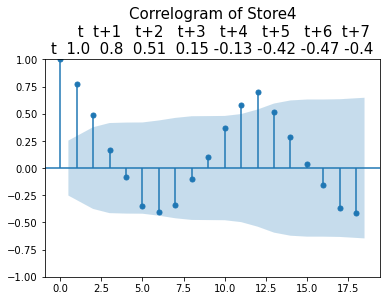

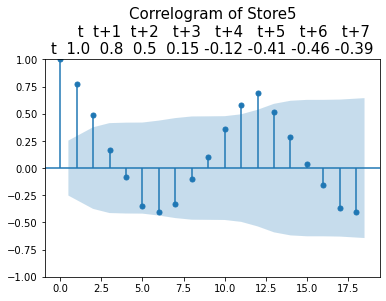

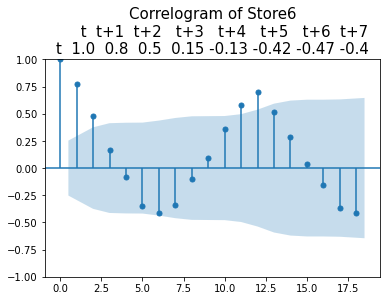

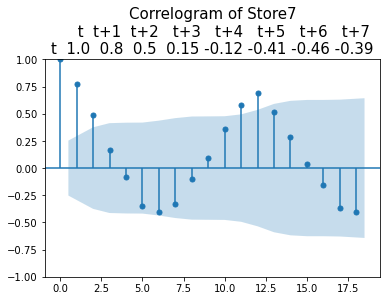

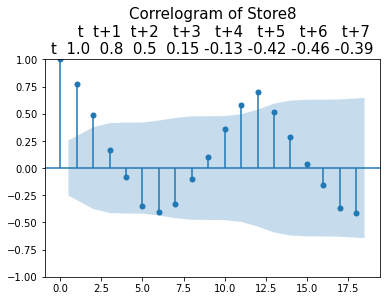

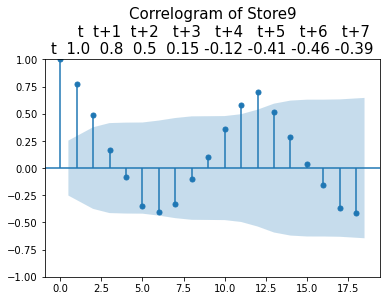

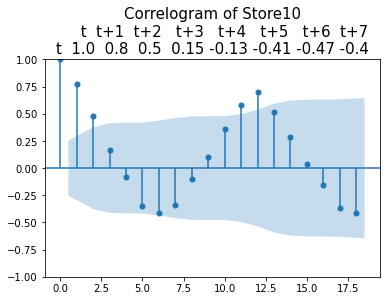

In [57]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
i=[]
for i in df['store'].unique():
    store_i = df.loc[df['store'] == i]
    store_i = store_i.groupby('date')['sales'].sum().reset_index()
    store_i = store_i.set_index('date')
    store_i = store_i['sales'].resample('M').sum()
    # using shift function to shift the values.
    dataframe_i = pd.concat([store_i.shift(7),store_i.shift(6),store_i.shift(5),store_i.shift(4),
                       store_i.shift(3), store_i.shift(2),store_i.shift(1), store_i], axis=1)
    # naming the columns
    dataframe_i.columns = ['t', 't+1', 't+2', 't+3','t+4','t+5','t+6','t+7']
    # using corr() function to compute the correlation
    #result_i = dataframe_i.corr().head(1).values
    plot_acf(store_i)
    plt.title('Correlogram of Store'+ str(i)+ '\n' + str(dataframe_i.corr().head(1).round(2)), fontsize = 15)
    #print(dataframe_i.corr().head(1).values)
    
    

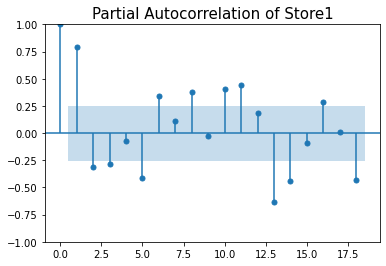

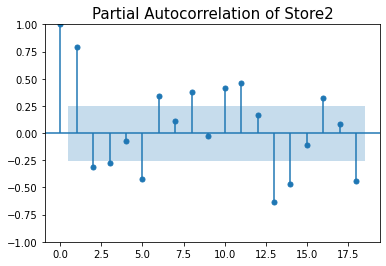

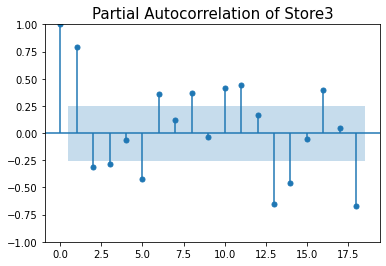

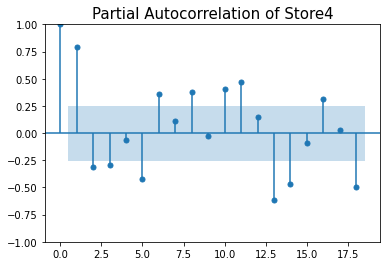

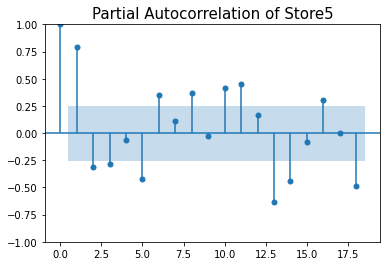

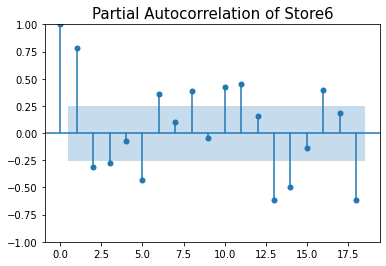

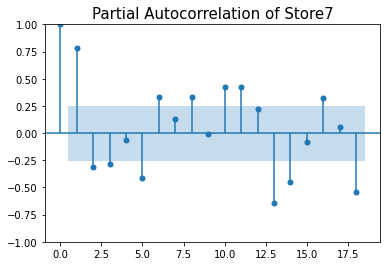

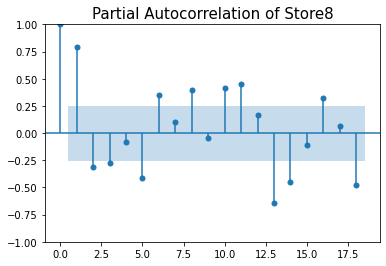

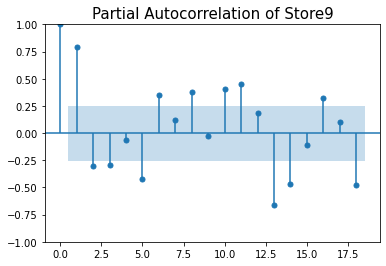

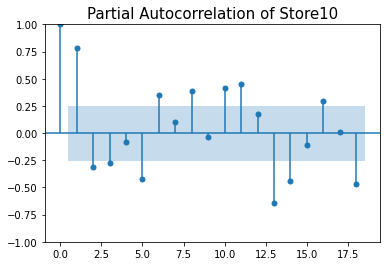

In [58]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

for i in df['store'].unique():
    store_i = df.loc[df['store'] == i]
    store_i = store_i.groupby('date')['sales'].sum().reset_index()
    store_i = store_i.set_index('date')
    store_i = store_i['sales'].resample('M').sum()
    plot_pacf(store_i)
    plt.title('Partial Autocorrelation of Store'+ str(i), fontsize = 15)
    
    
    

# Time series forecasting with SARIMAX

In [69]:
df = pd.read_csv("forecast train.csv")

df['date'] = pd.to_datetime(df['date'])
import datetime
def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day'] = df.date.dt.day
    df['year'] = df.date.dt.year
    return df


In [70]:
!pip install pmdarima

In [71]:
from pmdarima import auto_arima


In [72]:

for i in df['store'].unique():
    store_i = df.loc[df['store'] == i]
    store_i = store_i.groupby('date')['sales'].sum().reset_index()
    store_i = store_i.set_index('date')
    store_i = store_i['sales'].resample('M').mean()
    store_i_train = store_i.iloc[:48]
    store_i_test = store_i.iloc[48:]
    print('Best model for store '+str(i))
    store_i_model = auto_arima(store_i,m=12,seasonal=True,trace=True)
    print('  ' ,store_i_model.summary())   
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')


Best model for store 1
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=2.00 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=509.051, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=512.111, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=512.275, Time=0.14 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=510.737, Time=0.09 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=510.853, Time=0.10 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=510.569, Time=0.05 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=510.533, Time=0.05 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=512.514, Time=0.12 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=510.926, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 3.339 seconds
                                        SARIMAX Results                                      
Dep. Variable:                              

In [73]:
for i in df['store'].unique():
    store_i = df.loc[df['store'] == i]
    store_i = store_i.groupby('date')['sales'].sum().reset_index()
    store_i = store_i.set_index('date')
    store_i = store_i['sales'].resample('M').mean()
    store_i_train = store_i.iloc[:48]
    store_i_test = store_i.iloc[48:]
    store_i_model = auto_arima(store_i,m=12,seasonal=True)           #,trace=True)
    print('Best model for store '+str(i)+':',store_i_model)


Best model for store 1:  ARIMA(0,1,0)(0,1,0)[12]          
Best model for store 2:  ARIMA(0,1,0)(0,1,0)[12]          
Best model for store 3:  ARIMA(0,1,0)(0,1,0)[12]          
Best model for store 4:  ARIMA(0,1,0)(0,1,0)[12]          
Best model for store 5:  ARIMA(0,1,0)(0,1,0)[12]          
Best model for store 6:  ARIMA(0,1,0)(0,1,0)[12]          
Best model for store 7:  ARIMA(0,1,0)(0,1,0)[12]          
Best model for store 8:  ARIMA(0,1,0)(0,1,0)[12]          
Best model for store 9:  ARIMA(0,1,0)(0,1,0)[12]          
Best model for store 10:  ARIMA(0,1,1)(2,1,0)[12]          


In [75]:
#Evaluation our model

from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.tools.eval_measures import rmse


from statsmodels.tsa.statespace.sarimax import SARIMAX

for i in df['store'].unique():
    store_i = df.loc[df['store'] == i]
    store_i = store_i.groupby('date')['sales'].sum().reset_index()
    store_i = store_i.set_index('date')
    store_i = store_i['sales'].resample('M').mean()
    store_i_train = store_i.iloc[:48]
    store_i_test = store_i.iloc[48:]
    start_i = len(store_i_train)
    end_i = len(store_i_train) + len(store_i_test) - 1

    
    store_i_model = auto_arima(store_i,m=12,seasonal=True)
    orders=[(0,1,0),(0,1,0),(0,1,0),(0,1,0),(0,1,0),(0,1,0),(0,1,0),(0,1,0),(0,1,0),(0,1,1)]
    seasonal_order=[(0,1,0,12),(0,1,0,12),(0,1,0,12),(0,1,0,12),(0,1,0,12),(0,1,0,12),(0,1,0,12),(0,1,0,12),(0,1,0,12),(2,1,0,12)]
    
    store_i_model = SARIMAX(store_i_train,order=orders[i-1],seasonal_order=seasonal_order[i-1],enforce_invertibility=False)
    store_i_result = store_i_model.fit()
    store_i_prediction = store_i_result.predict(start_i,end_i).rename('SARIMA model predictions')
    print('rmse of store'+str(i)+':',rmse(store_i_test,store_i_prediction))

rmse of store1: 84.00605349899561
rmse of store2: 99.89134081126008
rmse of store3: 79.34385672449186
rmse of store4: 77.54930681293042
rmse of store5: 61.16243642312346
rmse of store6: 52.507506234600314
rmse of store7: 52.03590672667766
rmse of store8: 100.49471951371982
rmse of store9: 63.818170080352594
rmse of store10: 40.117617326087625


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
store1


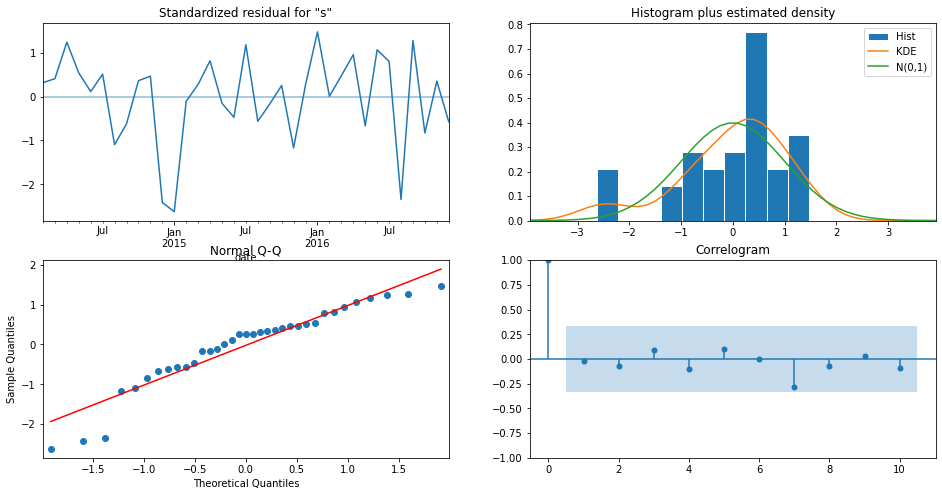

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
store2


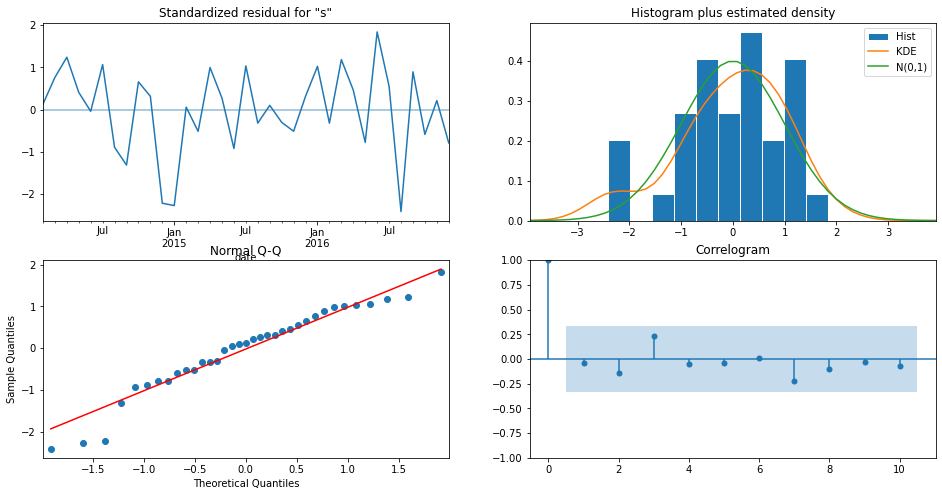

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
store3


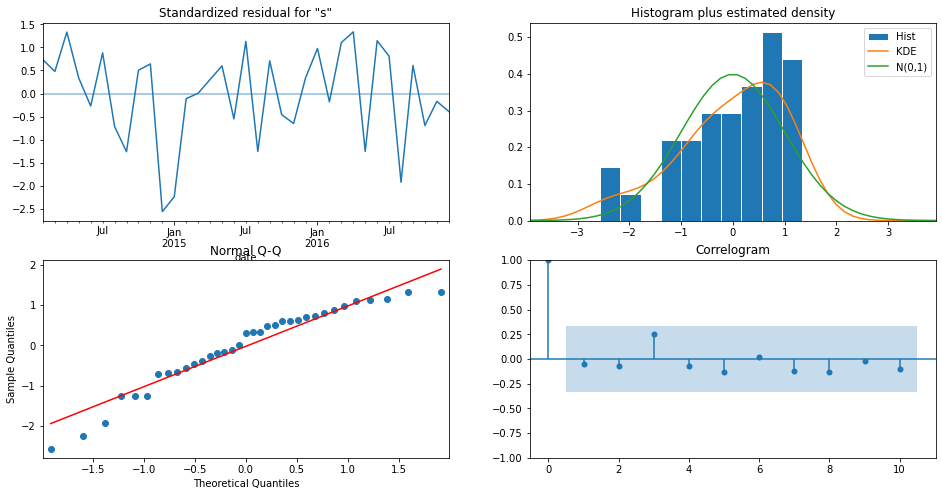

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
store4


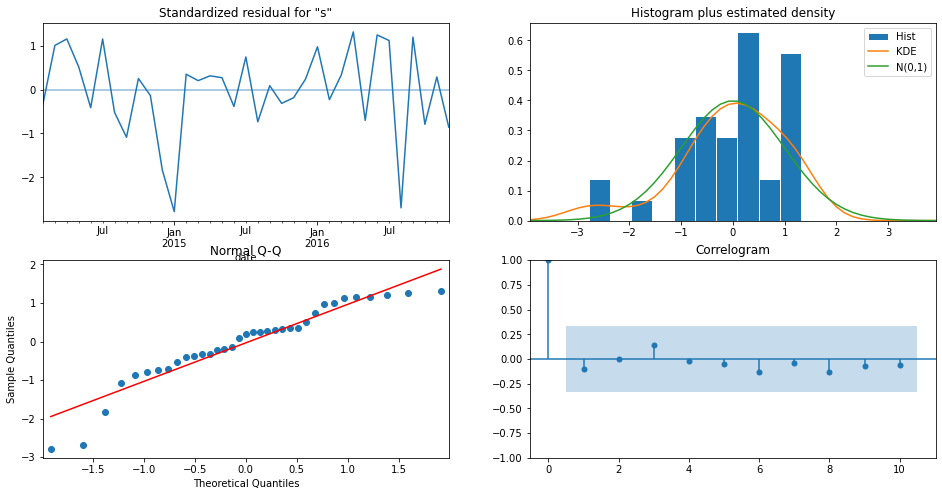

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
store5


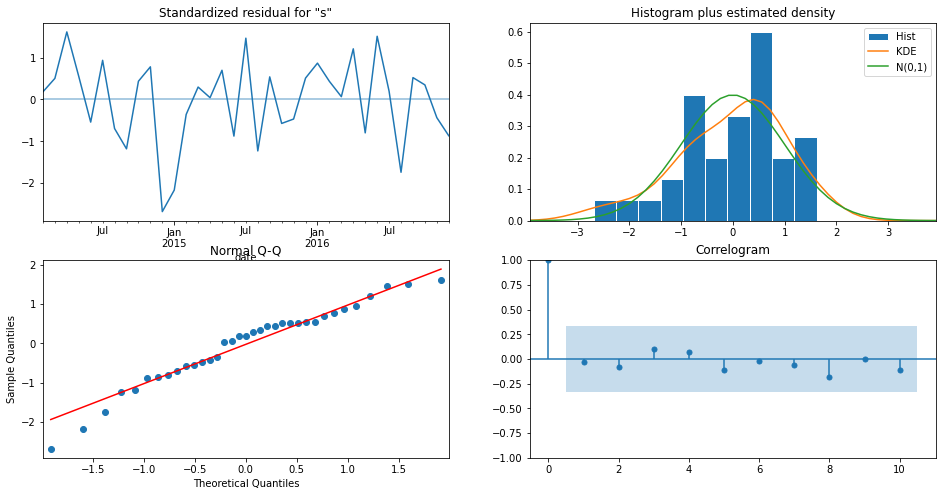

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
store6


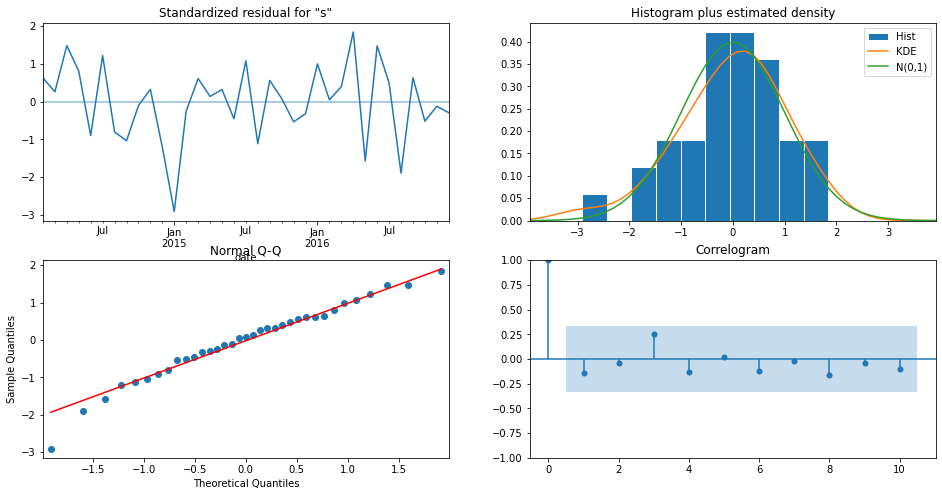

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
store7


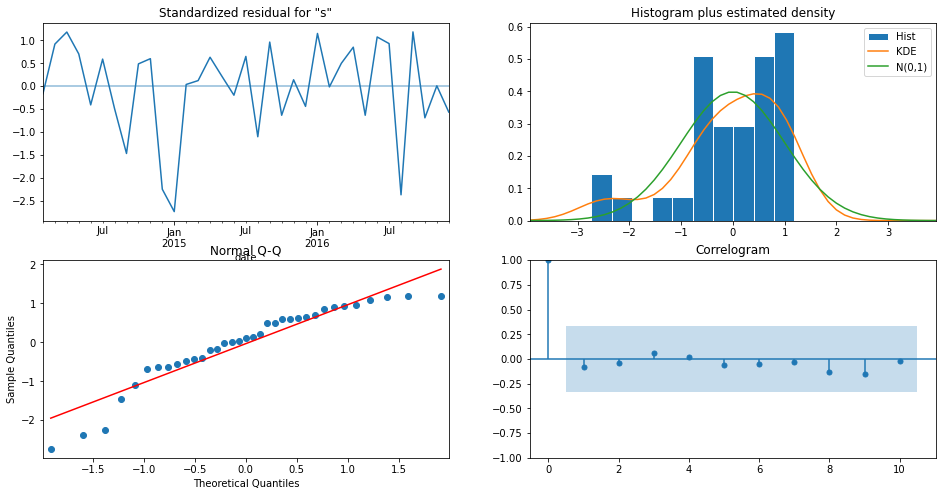

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
store8


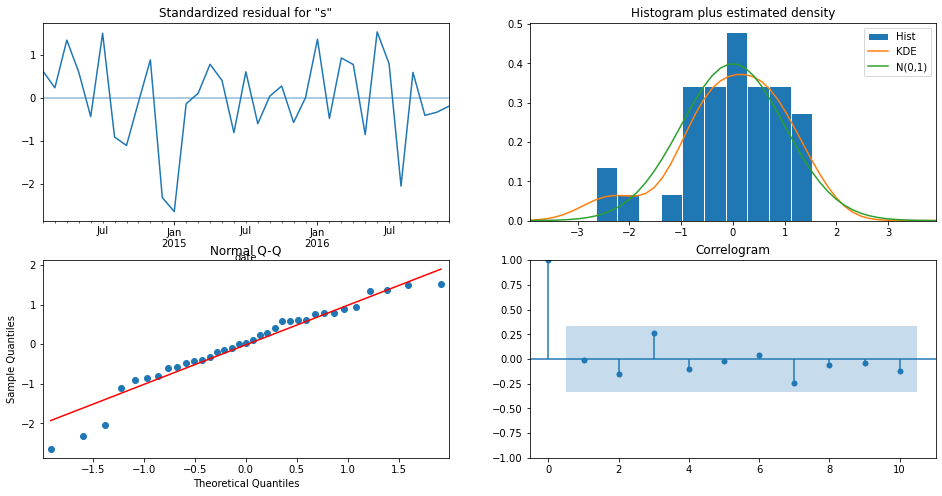

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
store9


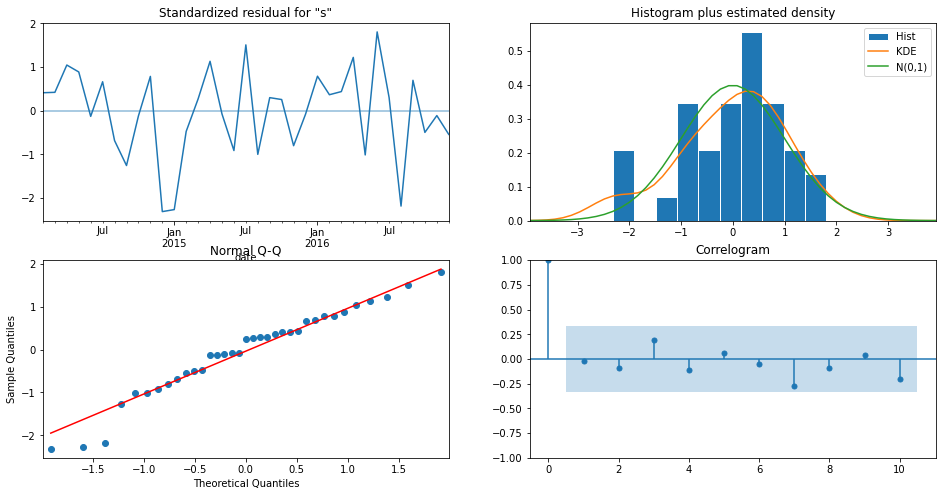

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
store10


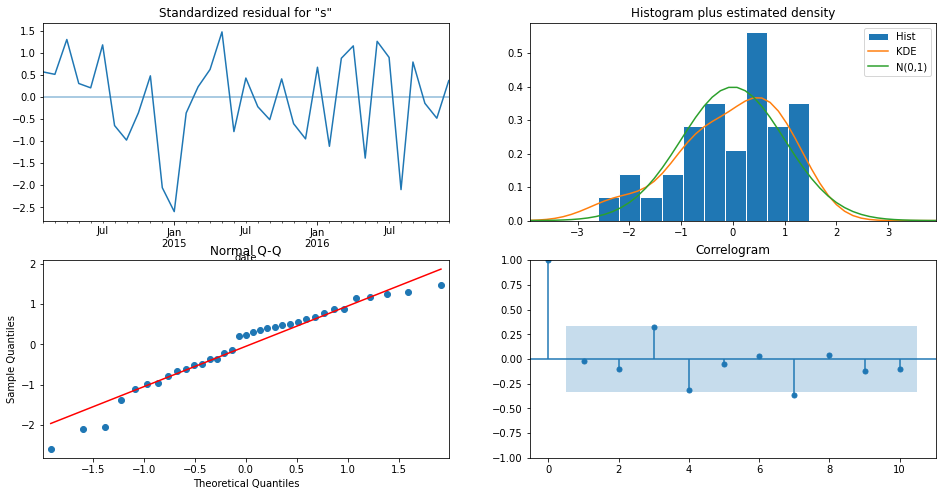

In [76]:



from statsmodels.tsa.statespace.sarimax import SARIMAX

for i in df['store'].unique():
    store_i = df.loc[df['store'] == i]
    store_i = store_i.groupby('date')['sales'].sum().reset_index()
    store_i = store_i.set_index('date')
    store_i = store_i['sales'].resample('M').mean()
    store_i_train = store_i.iloc[:48]
    store_i_test = store_i.iloc[48:]
    start_i = len(store_i_train)
    end_i = len(store_i_train) + len(store_i_test) - 1

    
    store_i_model = auto_arima(store_i,m=12,seasonal=True)
    orders=[(0,1,0),(0,1,0),(0,1,0),(0,1,0),(0,1,0),(0,1,0),(0,1,0),(0,1,0),(0,1,0),(0,1,1)]
    seasonal_order=[(0,1,0,12),(0,1,0,12),(0,1,0,12),(0,1,0,12),(0,1,0,12),(0,1,0,12),(0,1,0,12),(0,1,0,12),(0,1,0,12),(2,1,0,12)]
    
    store_i_model = SARIMAX(store_i_train,order=orders[i-1],seasonal_order=seasonal_order[i-1],enforce_invertibility=False)
    store_i_result = store_i_model.fit()
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('store'+str(i))
    store_i_result.plot_diagnostics(figsize=(16,8))
    plt.show()

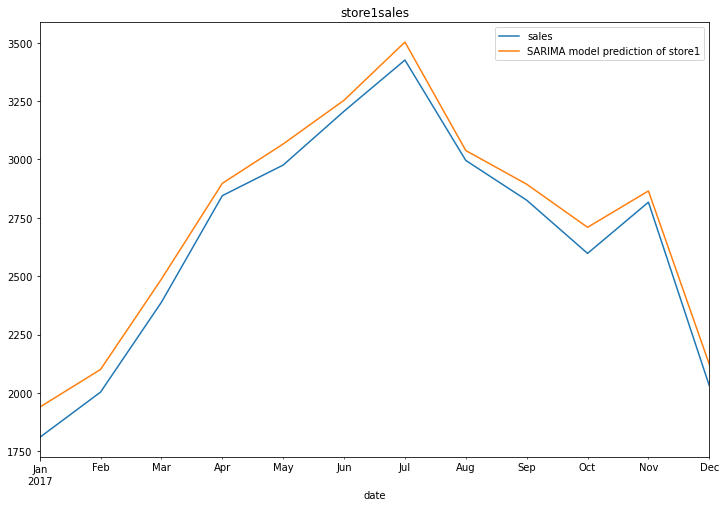

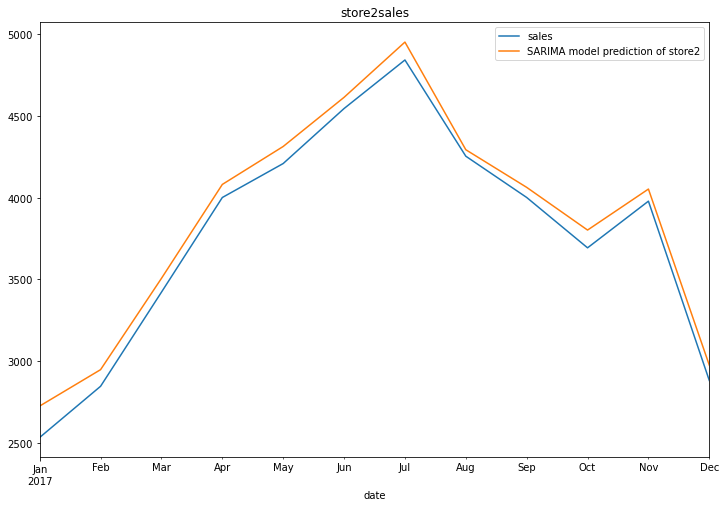

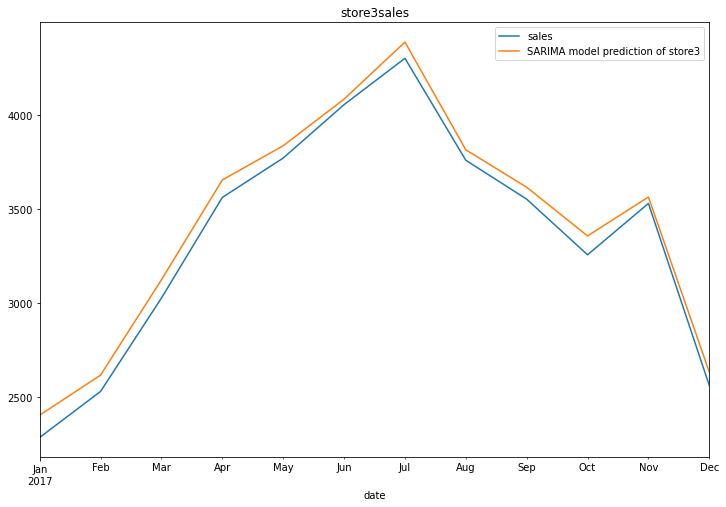

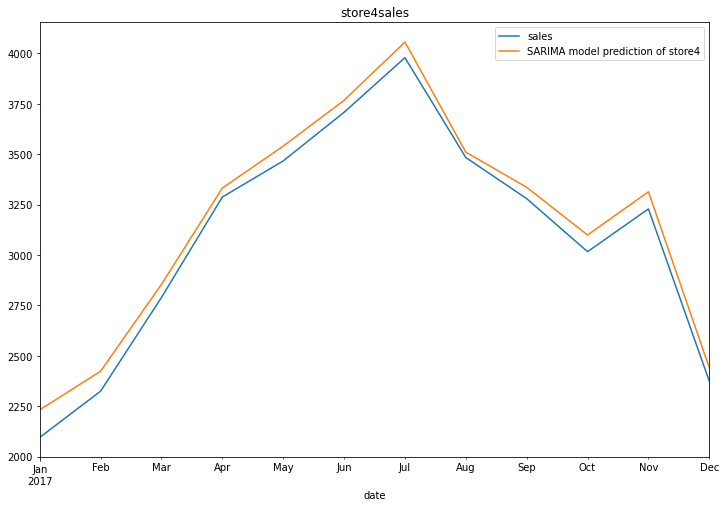

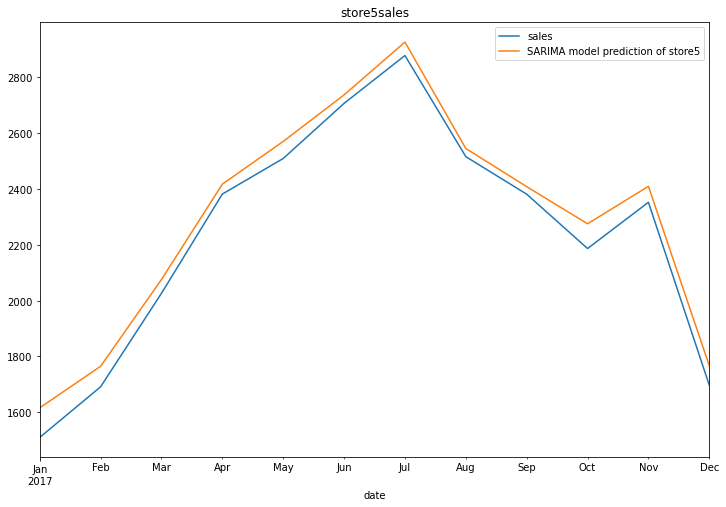

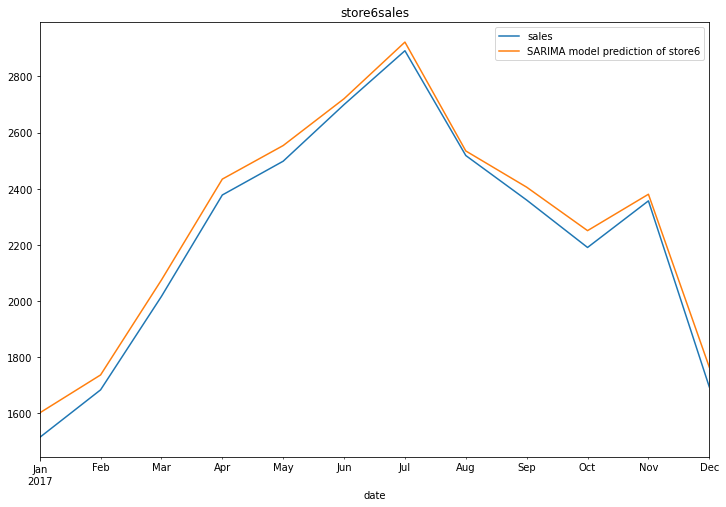

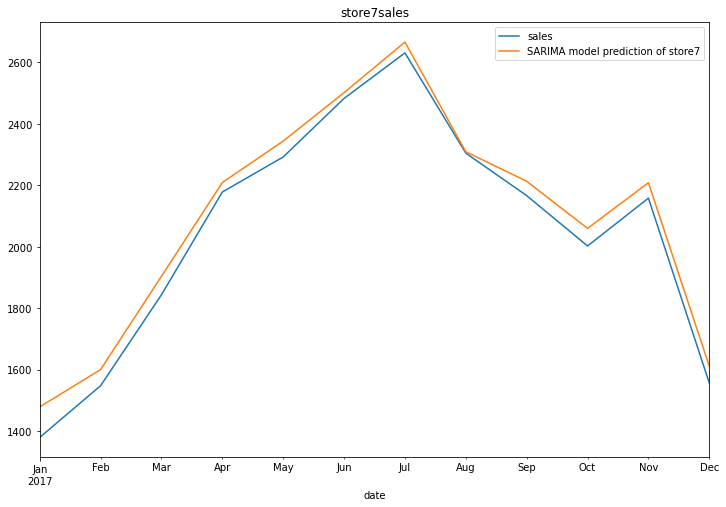

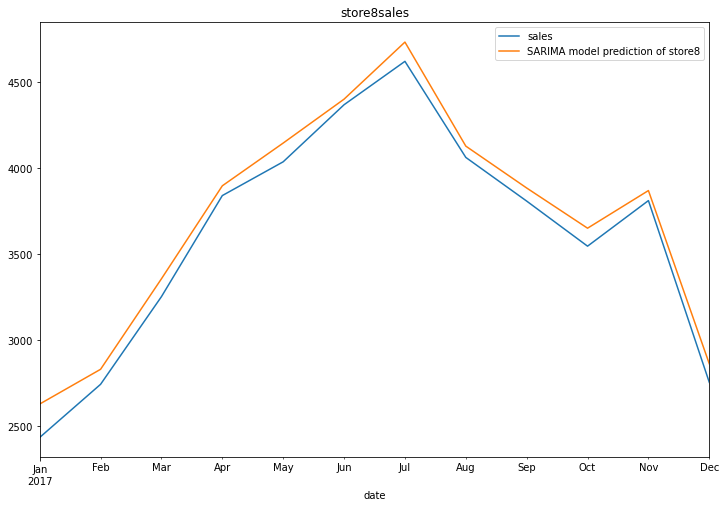

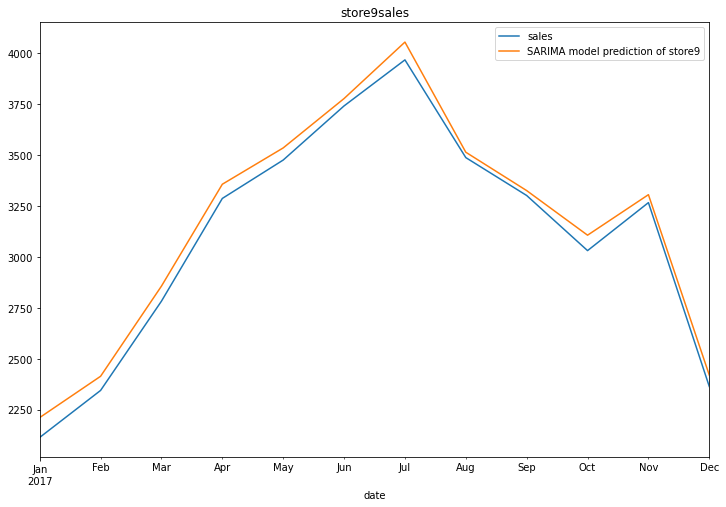

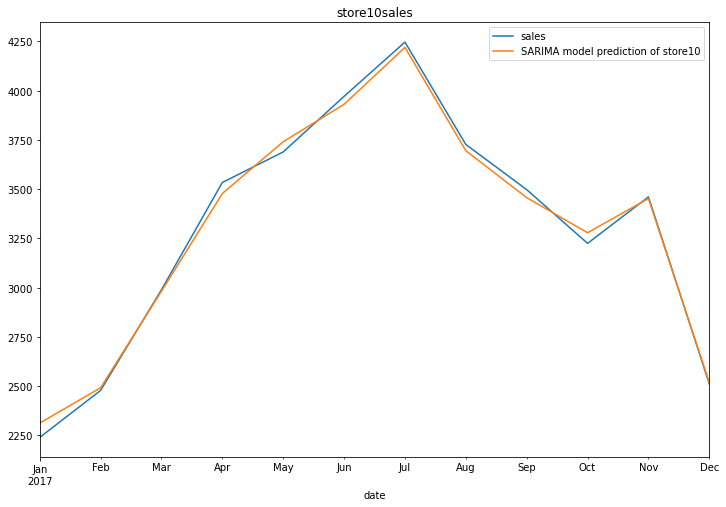

In [77]:



from statsmodels.tsa.statespace.sarimax import SARIMAX

for i in df['store'].unique():
    store_i = df.loc[df['store'] == i]
    store_i = store_i.groupby('date')['sales'].sum().reset_index()
    store_i = store_i.set_index('date')
    store_i = store_i['sales'].resample('M').mean()
    store_i_train = store_i.iloc[:48]
    store_i_test = store_i.iloc[48:]
    start_i = len(store_i_train)
    end_i = len(store_i_train) + len(store_i_test) - 1

    
    store_i_model = auto_arima(store_i,m=12,seasonal=True)
    orders=[(0,1,0),(0,1,0),(0,1,0),(0,1,0),(0,1,0),(0,1,0),(0,1,0),(0,1,0),(0,1,0),(0,1,1)]
    seasonal_order=[(0,1,0,12),(0,1,0,12),(0,1,0,12),(0,1,0,12),(0,1,0,12),(0,1,0,12),(0,1,0,12),(0,1,0,12),(0,1,0,12),(2,1,0,12)]
    
    store_i_model = SARIMAX(store_i_train,order=orders[i-1],seasonal_order=seasonal_order[i-1],enforce_invertibility=False)
    store_i_result = store_i_model.fit()
    store_i_prediction = store_i_result.predict(start_i,end_i).rename('SARIMA model prediction of store'+str(i))
    
    store_i_test.plot(figsize=(12,8),legend=True)
    store_i_prediction.plot(legend=True)
    plt.title("store" +str(i)+ "sales")
    plt.show()

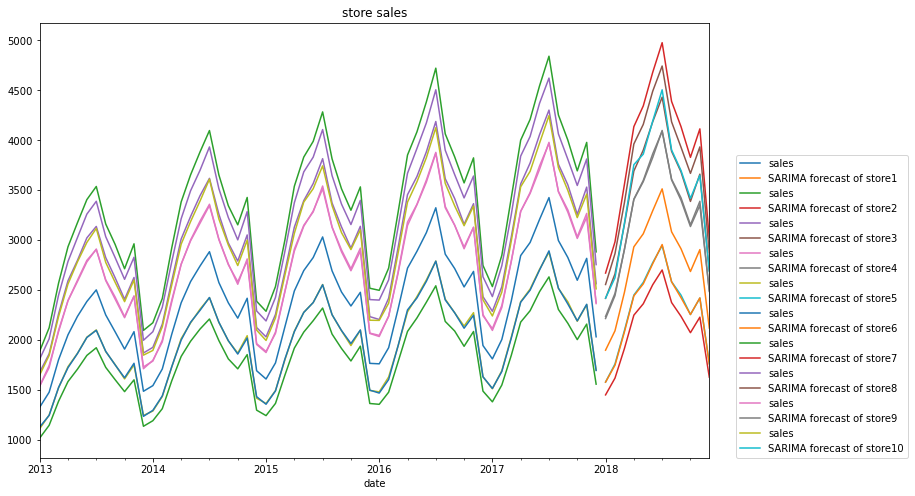

In [78]:




from statsmodels.tsa.statespace.sarimax import SARIMAX

for i in df['store'].unique():
    store_i = df.loc[df['store'] == i]
    store_i = store_i.groupby('date')['sales'].sum().reset_index()
    store_i = store_i.set_index('date')
    store_i = store_i['sales'].resample('M').mean()
    store_i_train = store_i.iloc[:48]
    store_i_test = store_i.iloc[48:]
    start_i = len(store_i_train)
    end_i = len(store_i_train) + len(store_i_test) - 1

    
    store_i_model = auto_arima(store_i,m=12,seasonal=True)
    orders=[(0,1,0),(0,1,0),(0,1,0),(0,1,0),(0,1,0),(0,1,0),(0,1,0),(0,1,0),(0,1,0),(0,1,1)]
    seasonal_order=[(0,1,0,12),(0,1,0,12),(0,1,0,12),(0,1,0,12),(0,1,0,12),(0,1,0,12),(0,1,0,12),(0,1,0,12),(0,1,0,12),(2,1,0,12)]
    
    
    store_i_model_final = SARIMAX(store_i,order=orders[i-1],seasonal_order=seasonal_order[i-1],enforce_invertibility=False)
    store_i_result_final = store_i_model_final.fit()
    store_i_forecast = store_i_result_final.predict(len(store_i),len(store_i)+11,typ='levels').rename('SARIMA forecast of store'+str(i))
    store_i.plot(legend=True,figsize=(12,8))
    store_i_forecast.plot(legend=True)
    plt.title("store sales")
    plt.legend(loc=(1.04, 0))
    


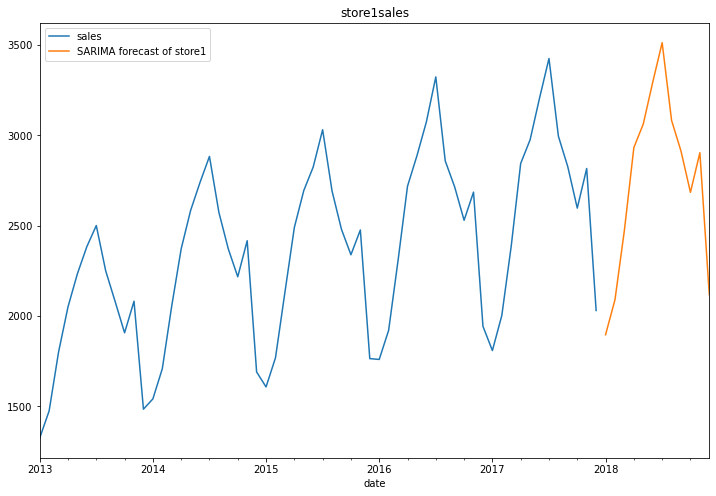

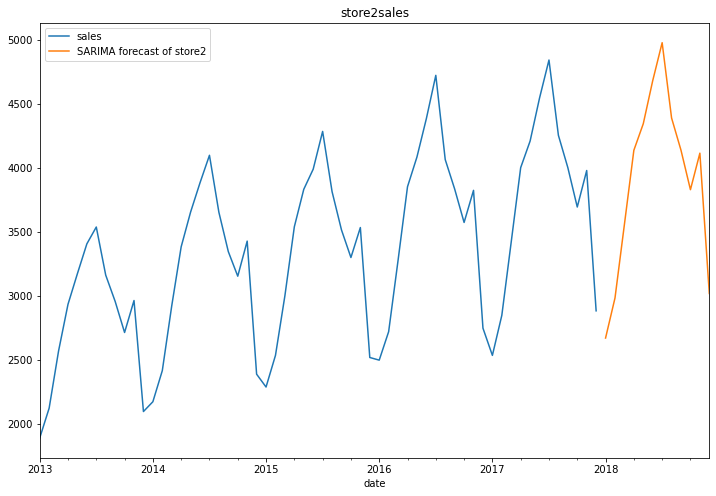

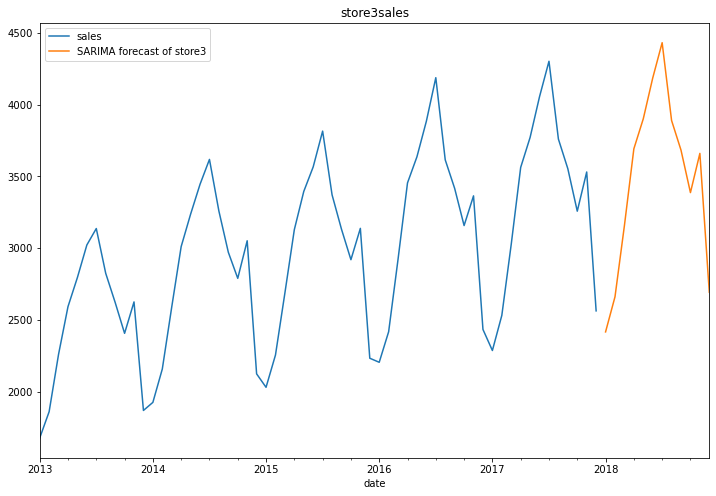

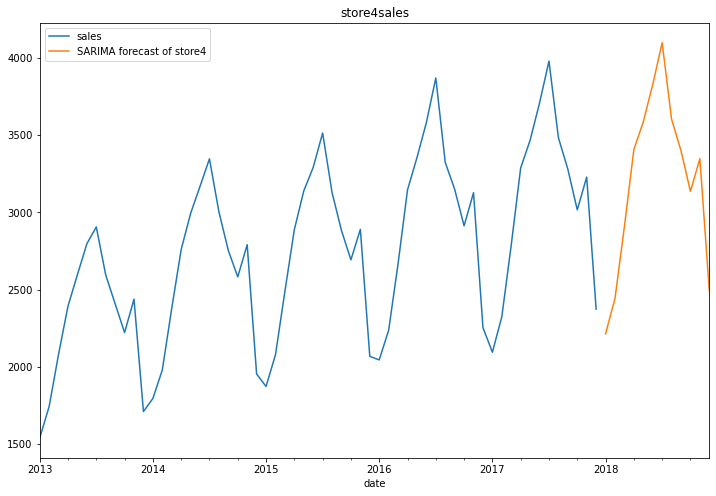

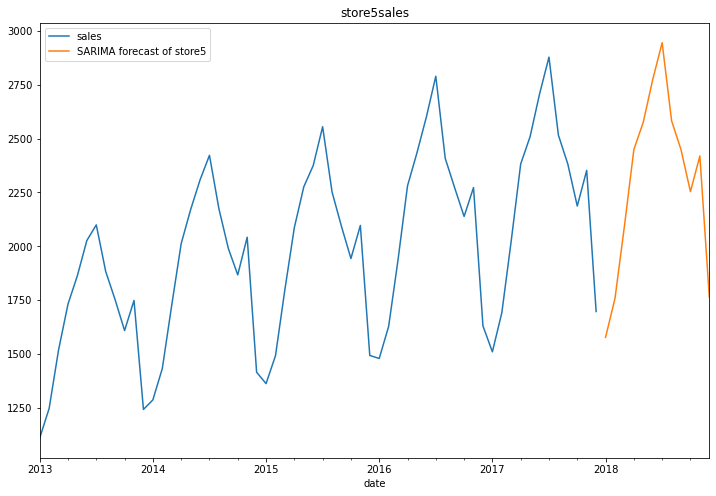

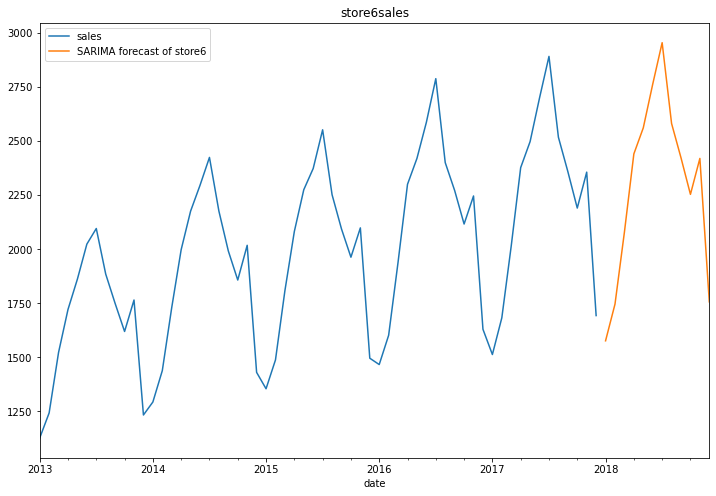

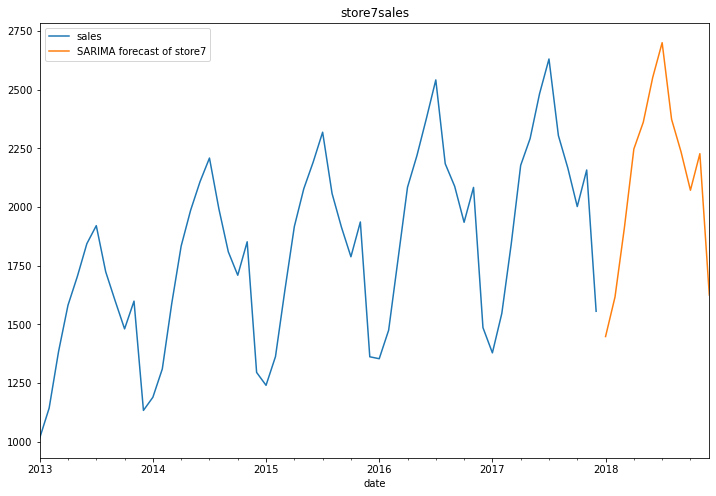

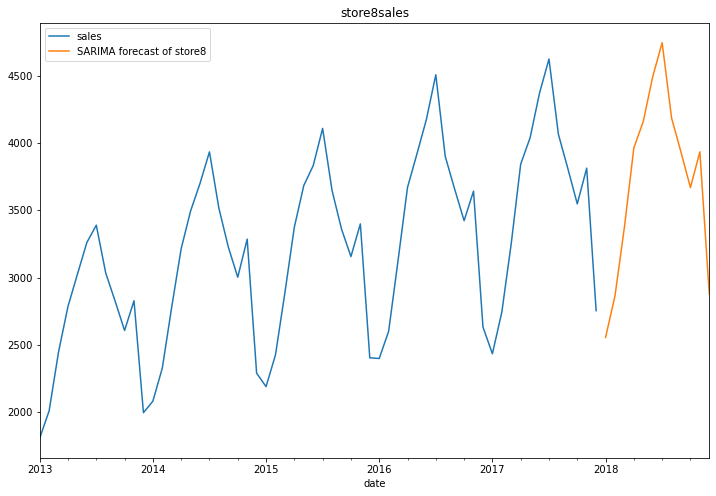

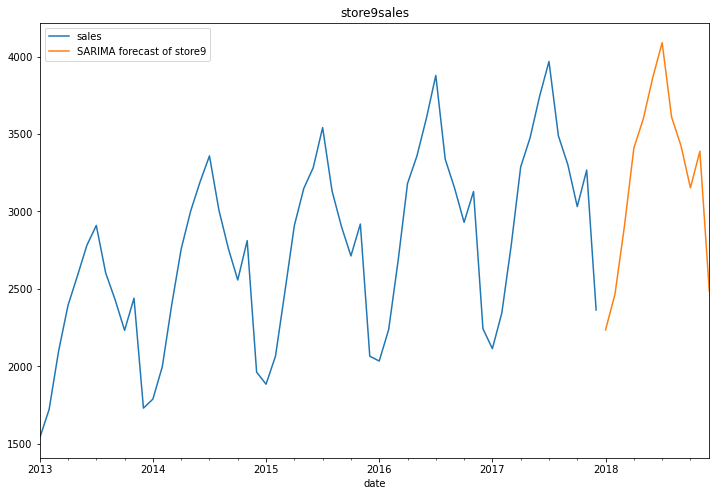

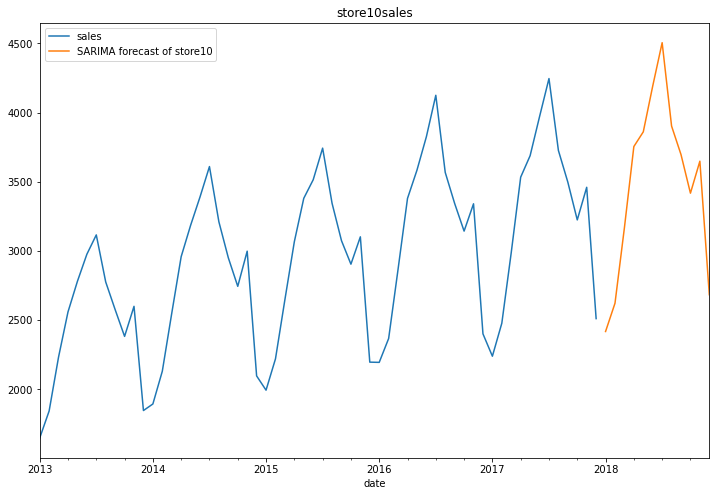

In [79]:
#Now let us forecast into the unknown future



from statsmodels.tsa.statespace.sarimax import SARIMAX

for i in df['store'].unique():
    store_i = df.loc[df['store'] == i]
    store_i = store_i.groupby('date')['sales'].sum().reset_index()
    store_i = store_i.set_index('date')
    store_i = store_i['sales'].resample('M').mean()
    store_i_train = store_i.iloc[:48]
    store_i_test = store_i.iloc[48:]
    start_i = len(store_i_train)
    end_i = len(store_i_train) + len(store_i_test) - 1

    
    store_i_model = auto_arima(store_i,m=12,seasonal=True)
    orders=[(0,1,0),(0,1,0),(0,1,0),(0,1,0),(0,1,0),(0,1,0),(0,1,0),(0,1,0),(0,1,0),(0,1,1)]
    seasonal_order=[(0,1,0,12),(0,1,0,12),(0,1,0,12),(0,1,0,12),(0,1,0,12),(0,1,0,12),(0,1,0,12),(0,1,0,12),(0,1,0,12),(2,1,0,12)]
    
    
    store_i_model_final = SARIMAX(store_i,order=orders[i-1],seasonal_order=seasonal_order[i-1],enforce_invertibility=False)
    store_i_result_final = store_i_model_final.fit()
    store_i_forecast = store_i_result_final.predict(len(store_i),len(store_i)+11,typ='levels').rename('SARIMA forecast of store'+str(i))
    store_i.plot(legend=True,figsize=(12,8))
    store_i_forecast.plot(legend=True)
    plt.title("store" +str(i)+ "sales")
    #plt.legend(loc=(1.04, 0))
    plt.show()


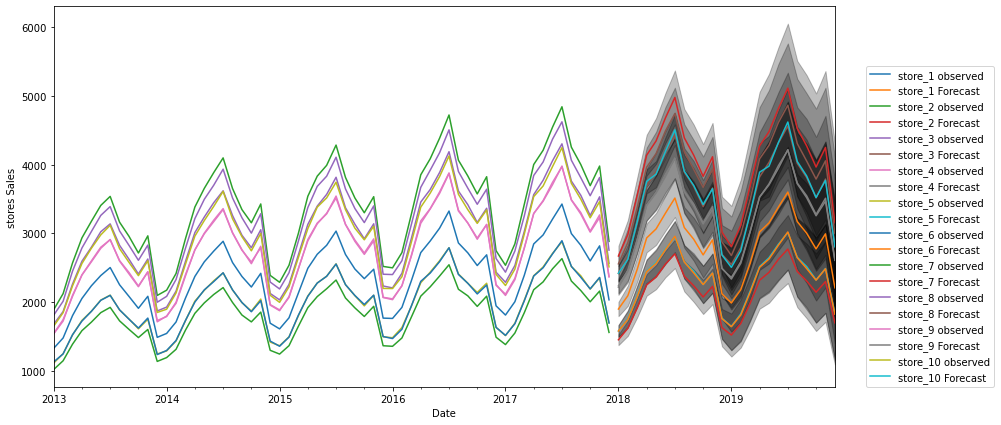

In [80]:
#Now let us forecast into the unknown future



from statsmodels.tsa.statespace.sarimax import SARIMAX

for i in df['store'].unique():
    store_i = df.loc[df['store'] == i]
    store_i = store_i.groupby('date')['sales'].sum().reset_index()
    store_i = store_i.set_index('date')
    store_i = store_i['sales'].resample('M').mean()
    store_i_train = store_i.iloc[:48]
    store_i_test = store_i.iloc[48:]
    start_i = len(store_i_train)
    end_i = len(store_i_train) + len(store_i_test) - 1

    
    store_i_model = auto_arima(store_i,m=12,seasonal=True)
    orders=[(0,1,0),(0,1,0),(0,1,0),(0,1,0),(0,1,0),(0,1,0),(0,1,0),(0,1,0),(0,1,0),(0,1,1)]
    seasonal_order=[(0,1,0,12),(0,1,0,12),(0,1,0,12),(0,1,0,12),(0,1,0,12),(0,1,0,12),(0,1,0,12),(0,1,0,12),(0,1,0,12),(2,1,0,12)]
    
    store_i_model_final = SARIMAX(store_i,order=orders[i-1],seasonal_order=seasonal_order[i-1],enforce_invertibility=False)
    store_i_result_final = store_i_model_final.fit()
    store_i_pred = store_i_result_final.get_forecast(steps=24)
    store_i_pred_ci = store_i_pred.conf_int()
    ax = store_i.plot(label='store_'+str(i)+ ' observed',figsize=(14,7))
    store_i_pred.predicted_mean.plot(ax=ax,label='store_'+str(i)+ ' Forecast')
    ax.fill_between(store_i_pred_ci.index,
               store_i_pred_ci.iloc[:,0],
               store_i_pred_ci.iloc[:,1],color='k',alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel('stores Sales')
    plt.legend(loc=(1.04, 0))
    #plt.show()
    
    
    
    
    
    


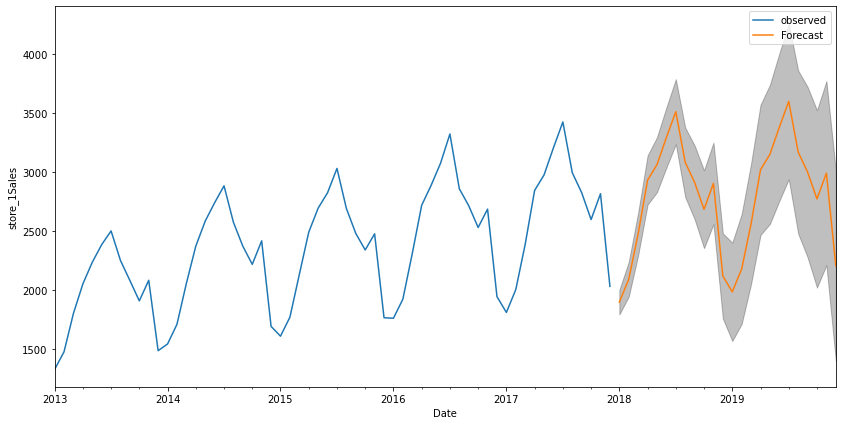

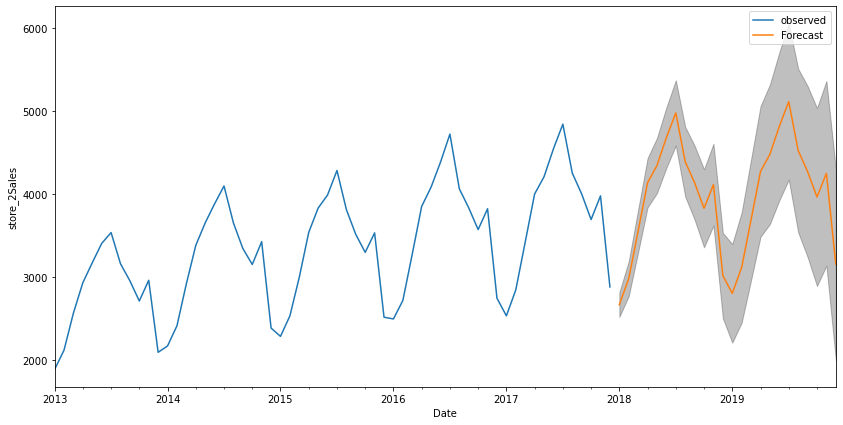

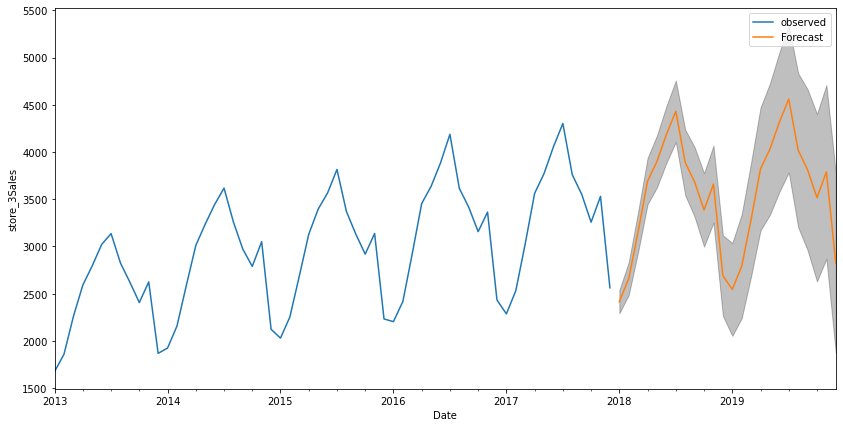

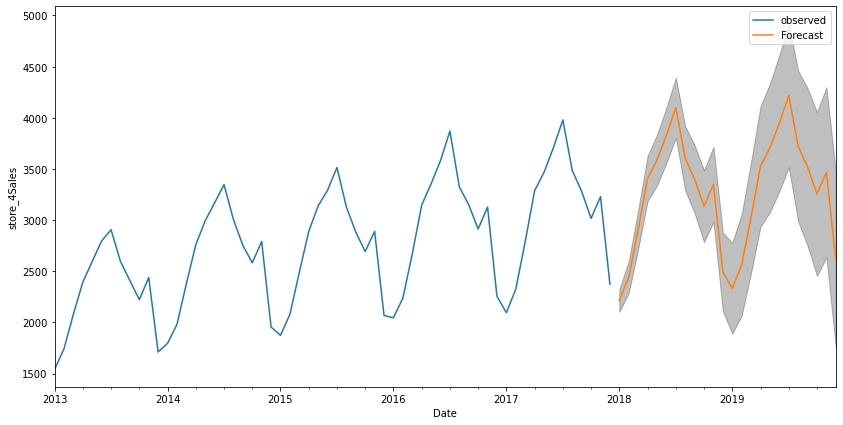

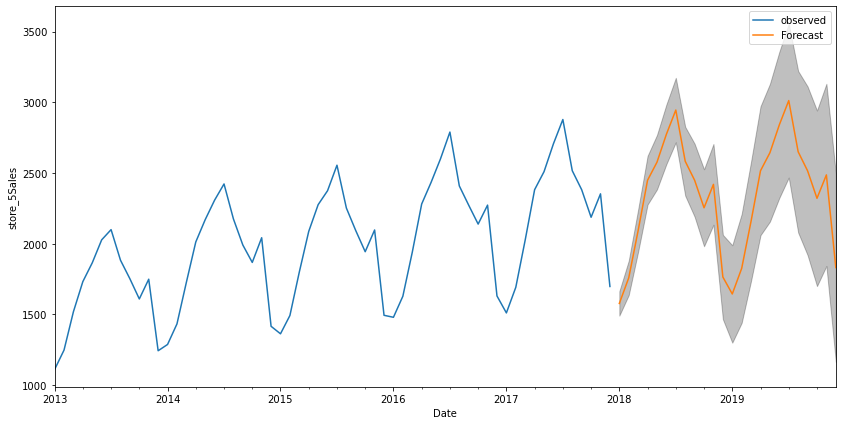

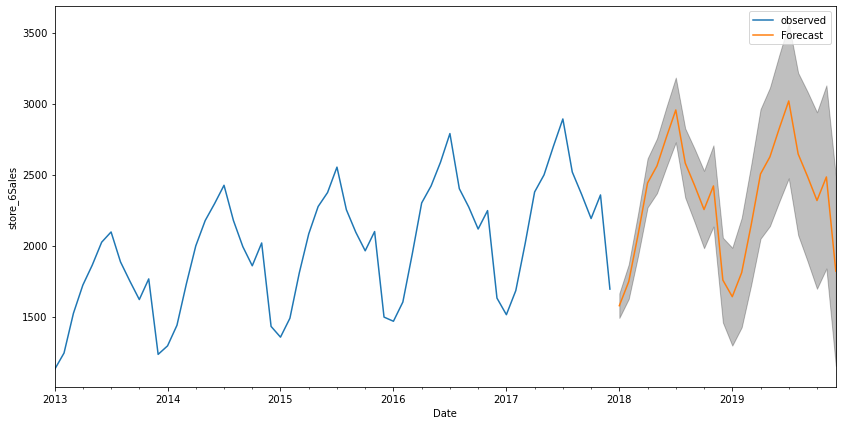

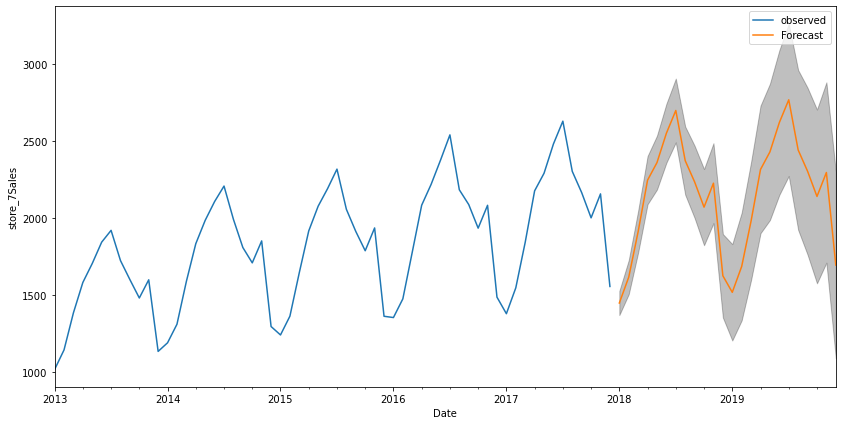

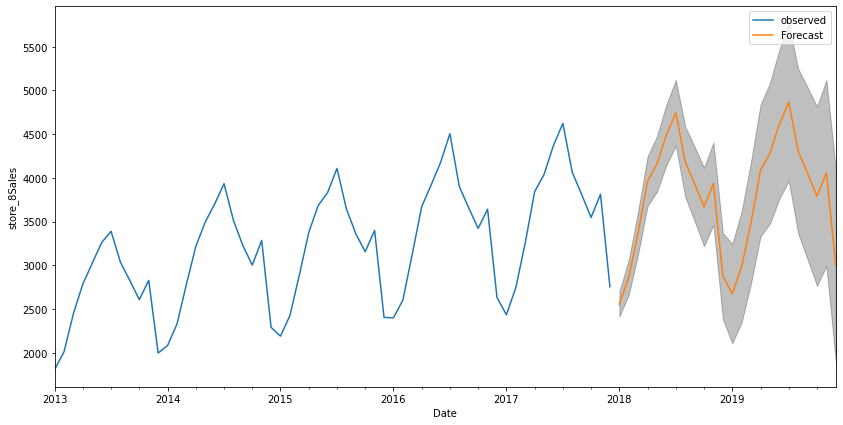

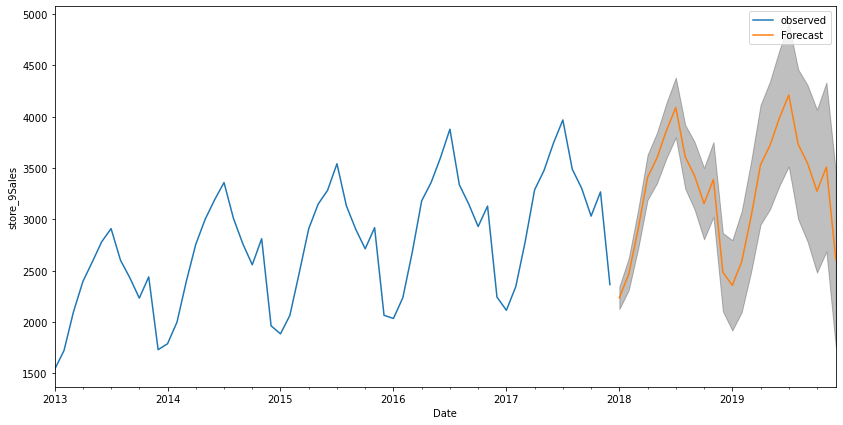

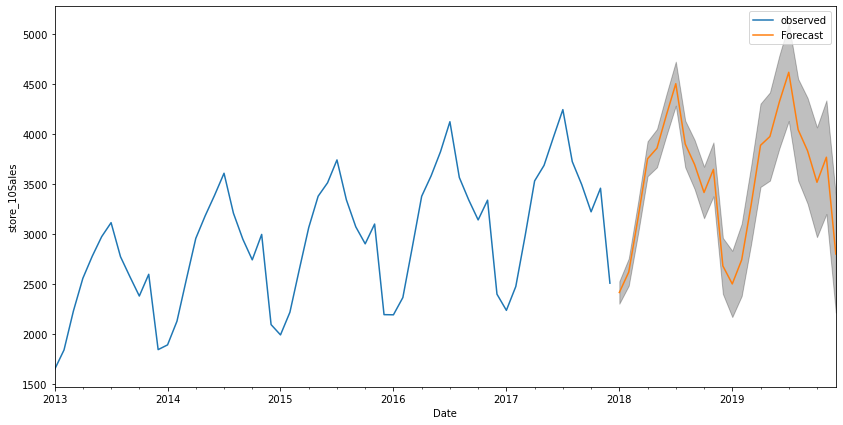

In [81]:
#Now let us forecast into the unknown future



from statsmodels.tsa.statespace.sarimax import SARIMAX

for i in df['store'].unique():
    store_i = df.loc[df['store'] == i]
    store_i = store_i.groupby('date')['sales'].sum().reset_index()
    store_i = store_i.set_index('date')
    store_i = store_i['sales'].resample('M').mean()
    store_i_train = store_i.iloc[:48]
    store_i_test = store_i.iloc[48:]
    start_i = len(store_i_train)
    end_i = len(store_i_train) + len(store_i_test) - 1

    
    store_i_model = auto_arima(store_i,m=12,seasonal=True)
    orders=[(0,1,0),(0,1,0),(0,1,0),(0,1,0),(0,1,0),(0,1,0),(0,1,0),(0,1,0),(0,1,0),(0,1,1)]
    seasonal_order=[(0,1,0,12),(0,1,0,12),(0,1,0,12),(0,1,0,12),(0,1,0,12),(0,1,0,12),(0,1,0,12),(0,1,0,12),(0,1,0,12),(2,1,0,12)]
    
    store_i_model_final = SARIMAX(store_i,order=orders[i-1],seasonal_order=seasonal_order[i-1],enforce_invertibility=False)
    store_i_result_final = store_i_model_final.fit()
    store_i_pred = store_i_result_final.get_forecast(steps=24)
    store_i_pred_ci = store_i_pred.conf_int()
    ax = store_i.plot(label='observed',figsize=(14,7))
    store_i_pred.predicted_mean.plot(ax=ax,label='Forecast')
    ax.fill_between(store_i_pred_ci.index,
               store_i_pred_ci.iloc[:,0],
               store_i_pred_ci.iloc[:,1],color='k',alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel('store_' +str(i)+ 'Sales')
    plt.legend()
    plt.show()
    
    
    
    
    
    
